In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import art
from dotenv import load_dotenv
import random
from openpipe.client import OpenPipe

load_dotenv()

op_client = OpenPipe()
print("OpenPipe client initialized")

random.seed(42)


api = art.UnslothAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="2048-single-game", base_model="Qwen/Qwen2.5-7B-Instruct"
)

OpenPipe client initialized


train:   0%|          | 0/6 [00:00<?, ?it/s]

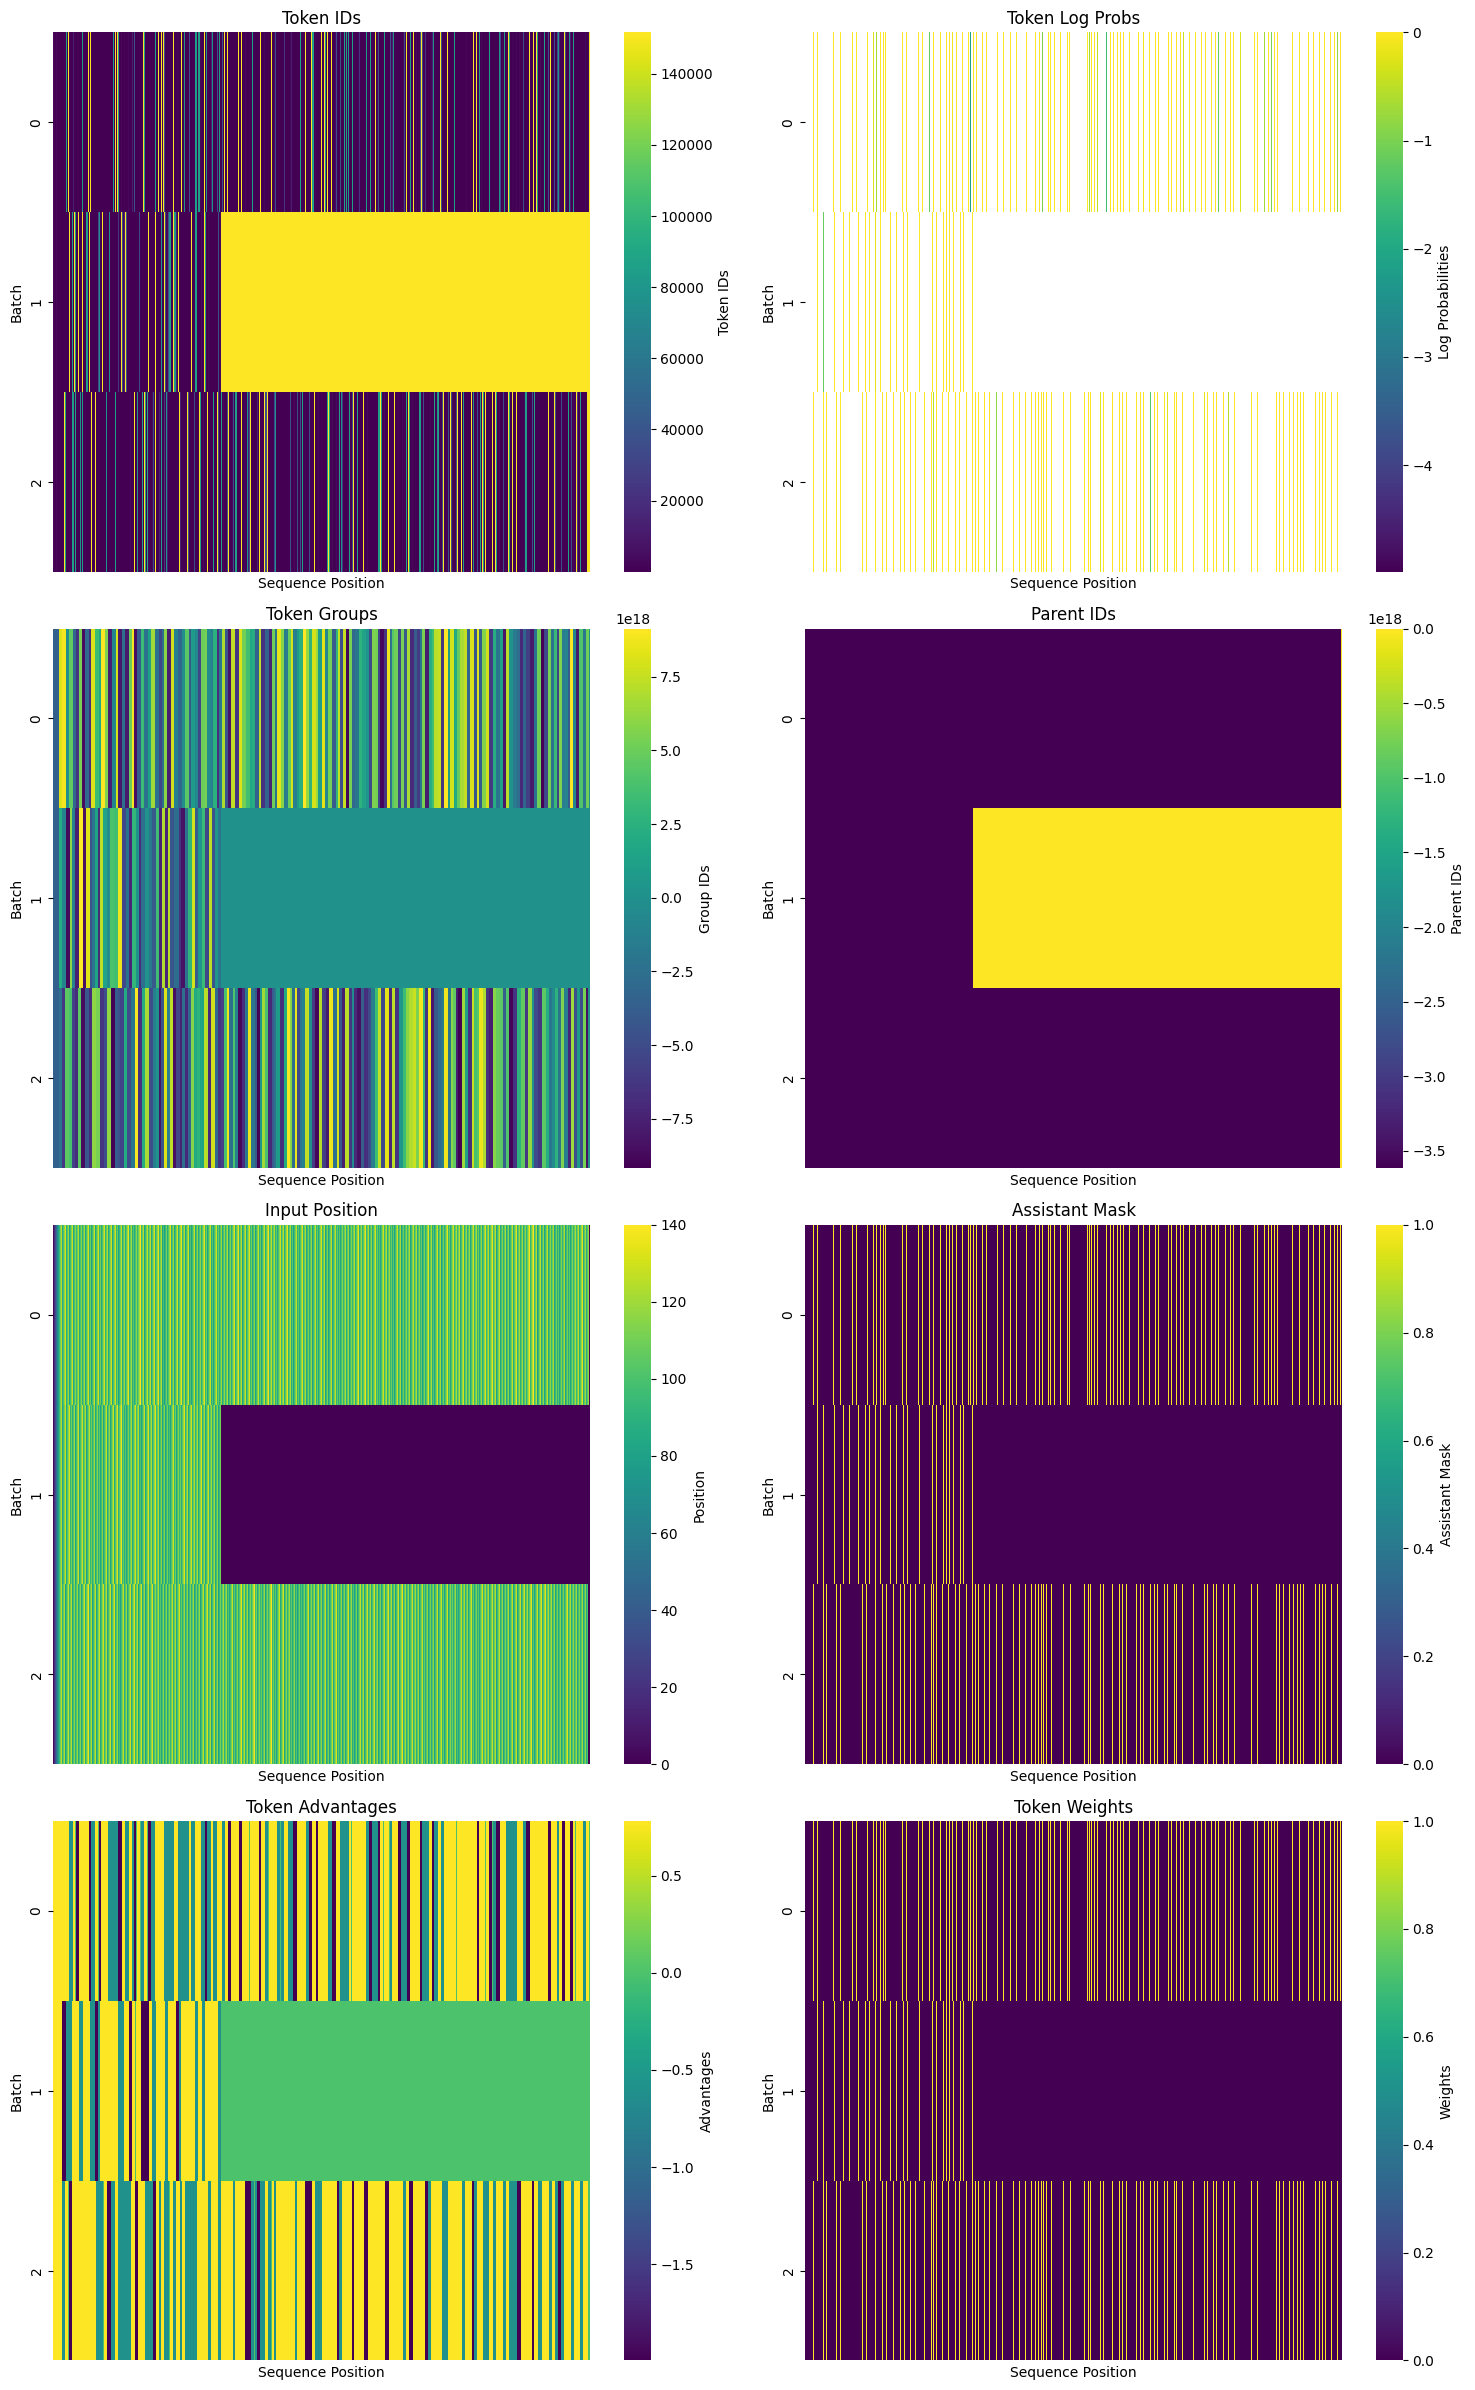

tune:   0%|          | 0/3 [00:00<?, ?it/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 3 | Total steps = 300,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 20,185,088/7,000,000,000 (0.29% trained)


Unsloth: Will smartly offload gradients to save VRAM!


train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0000


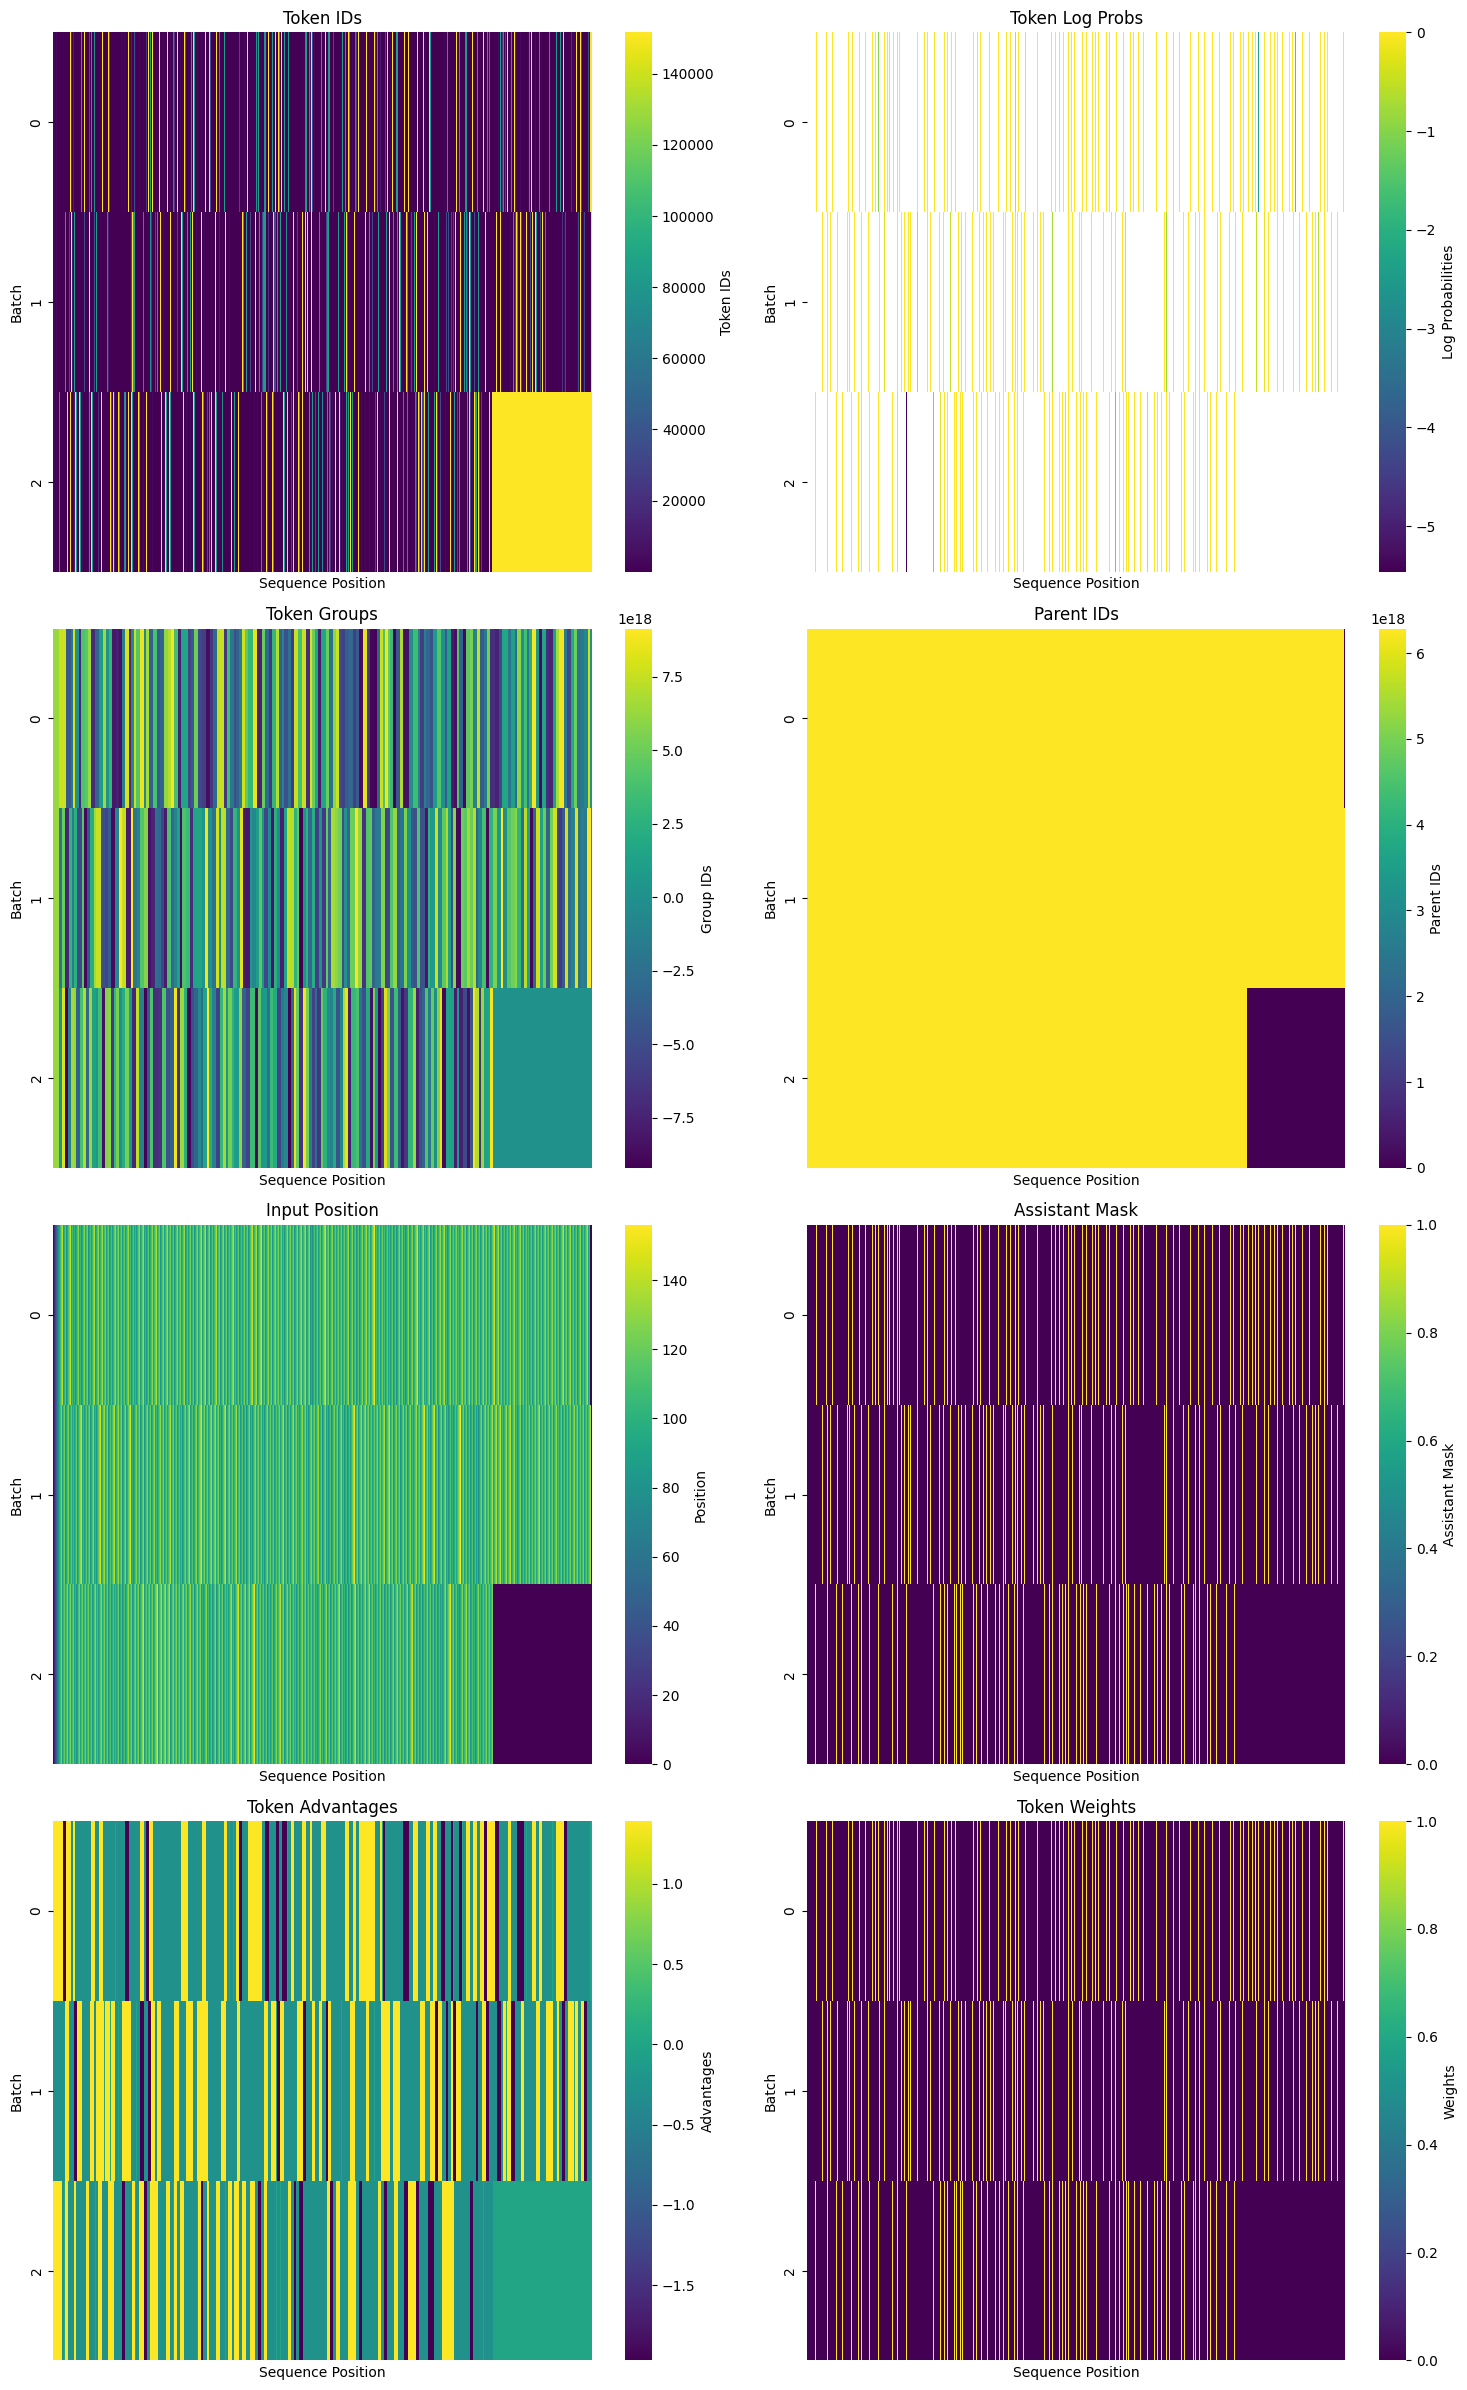

tune:   0%|          | 0/3 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0001


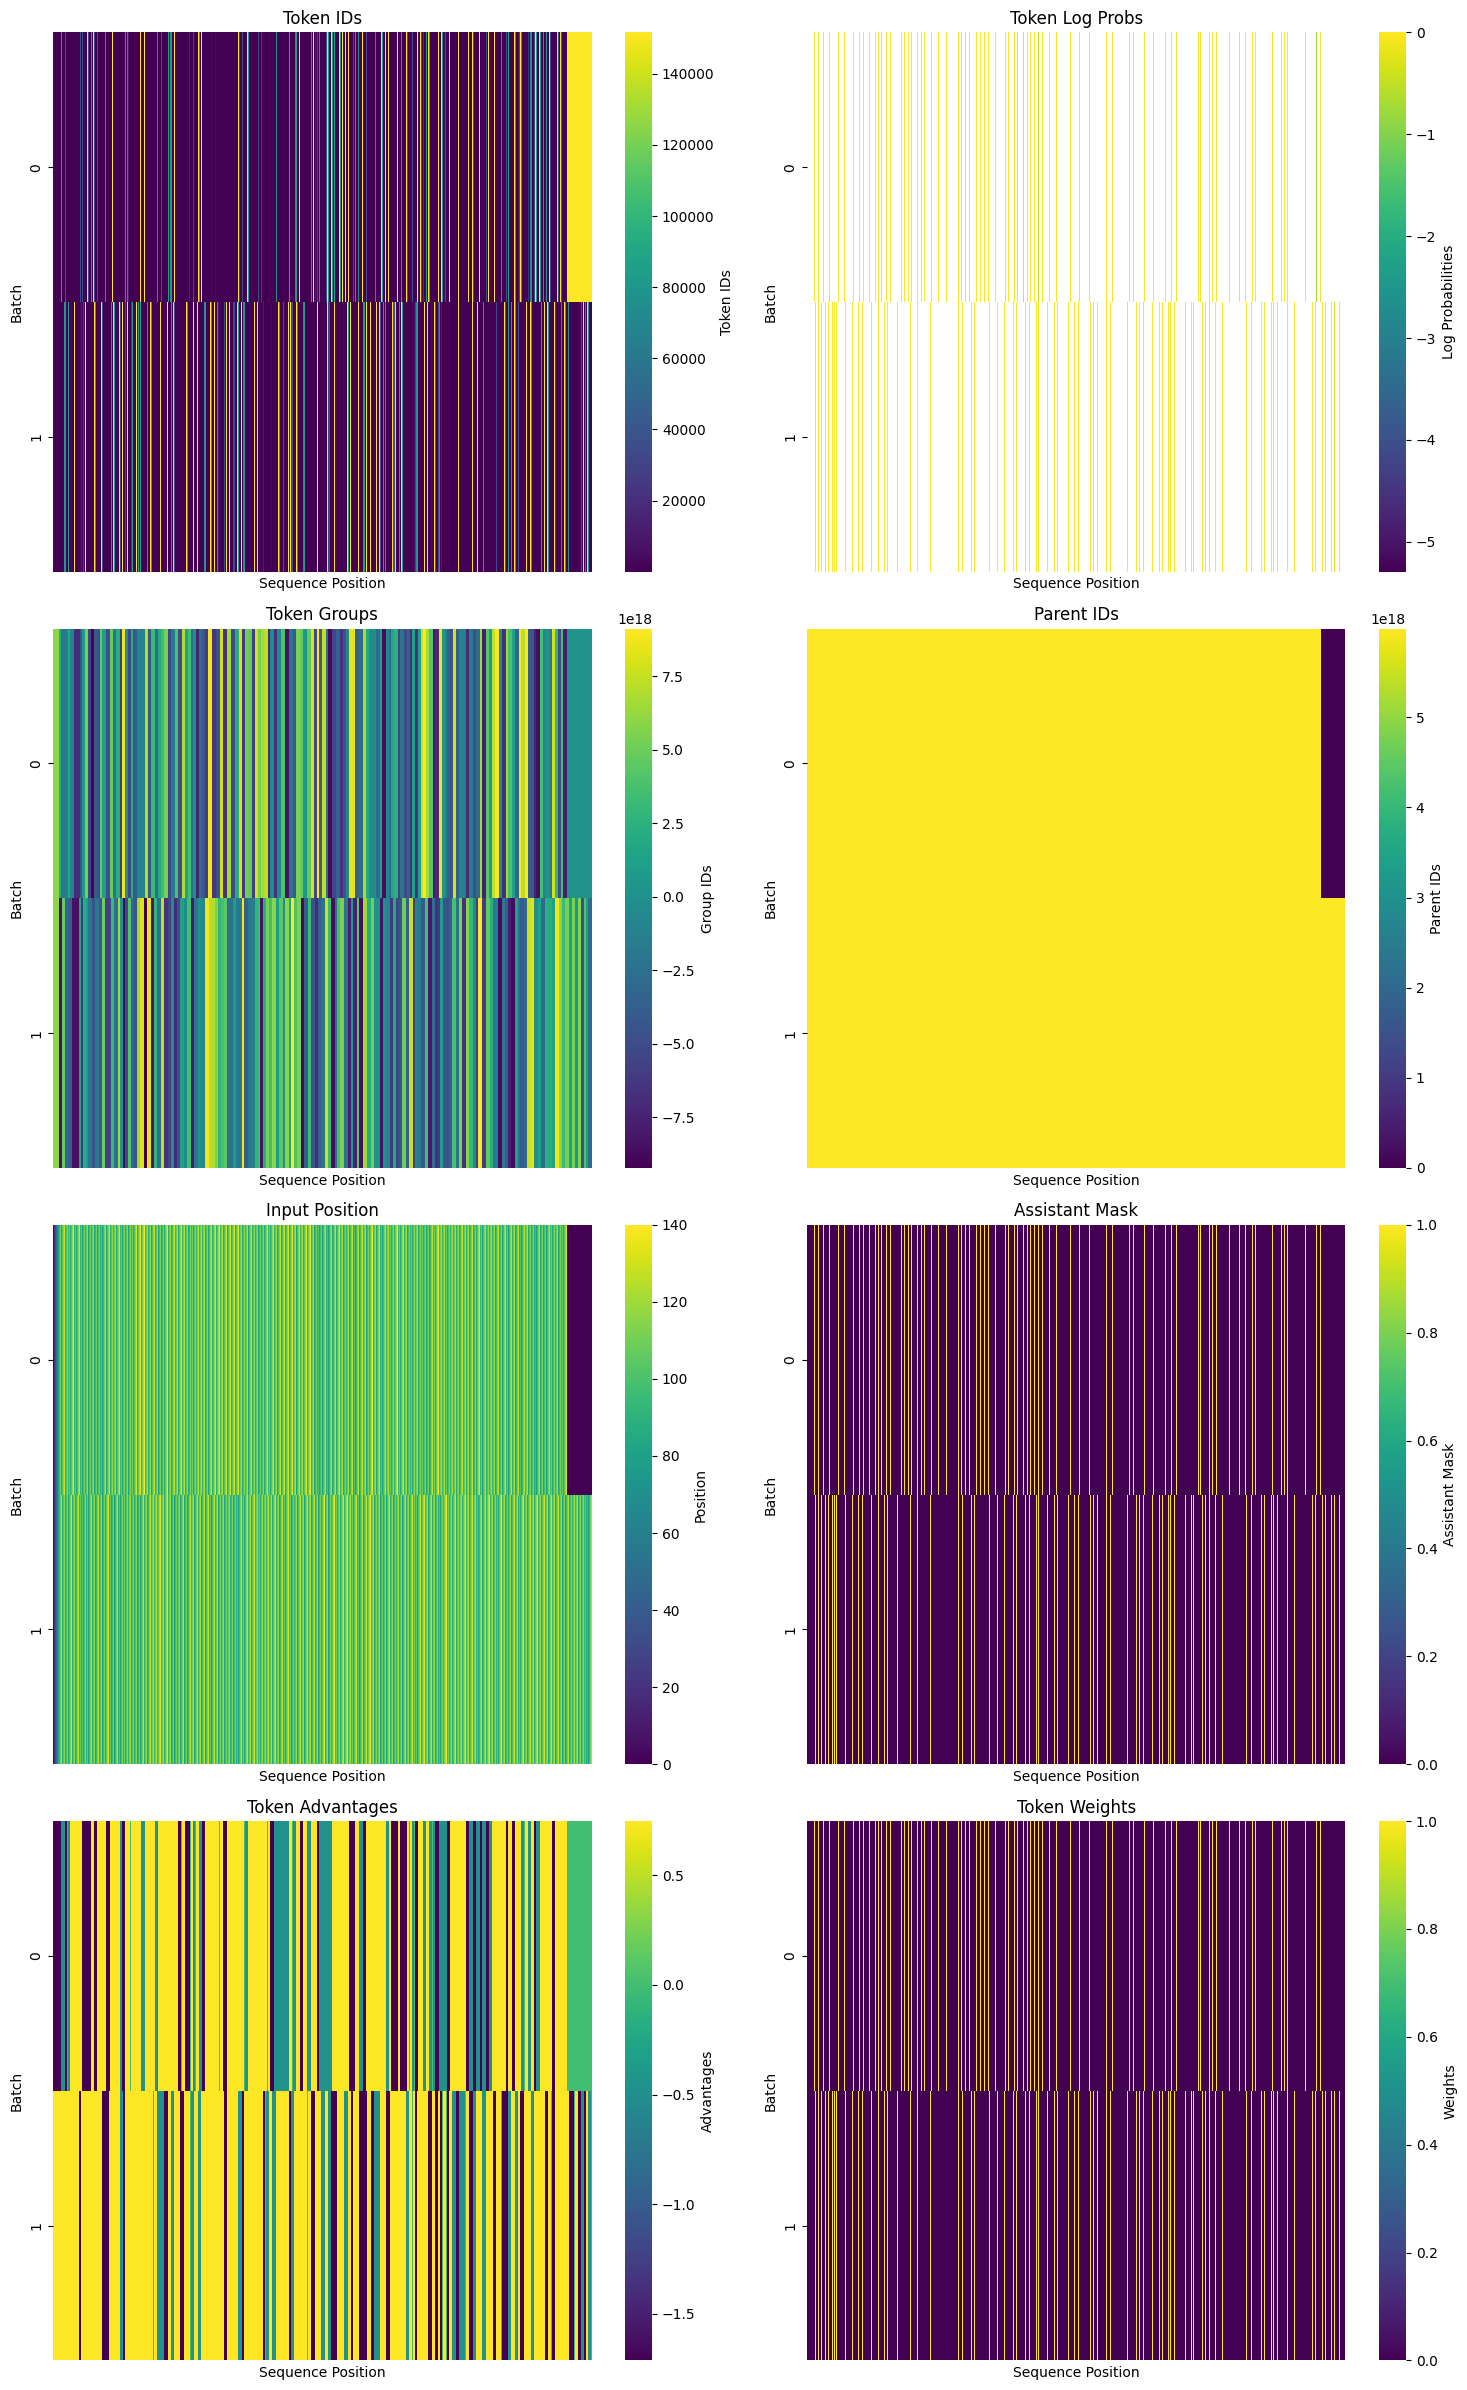

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0002


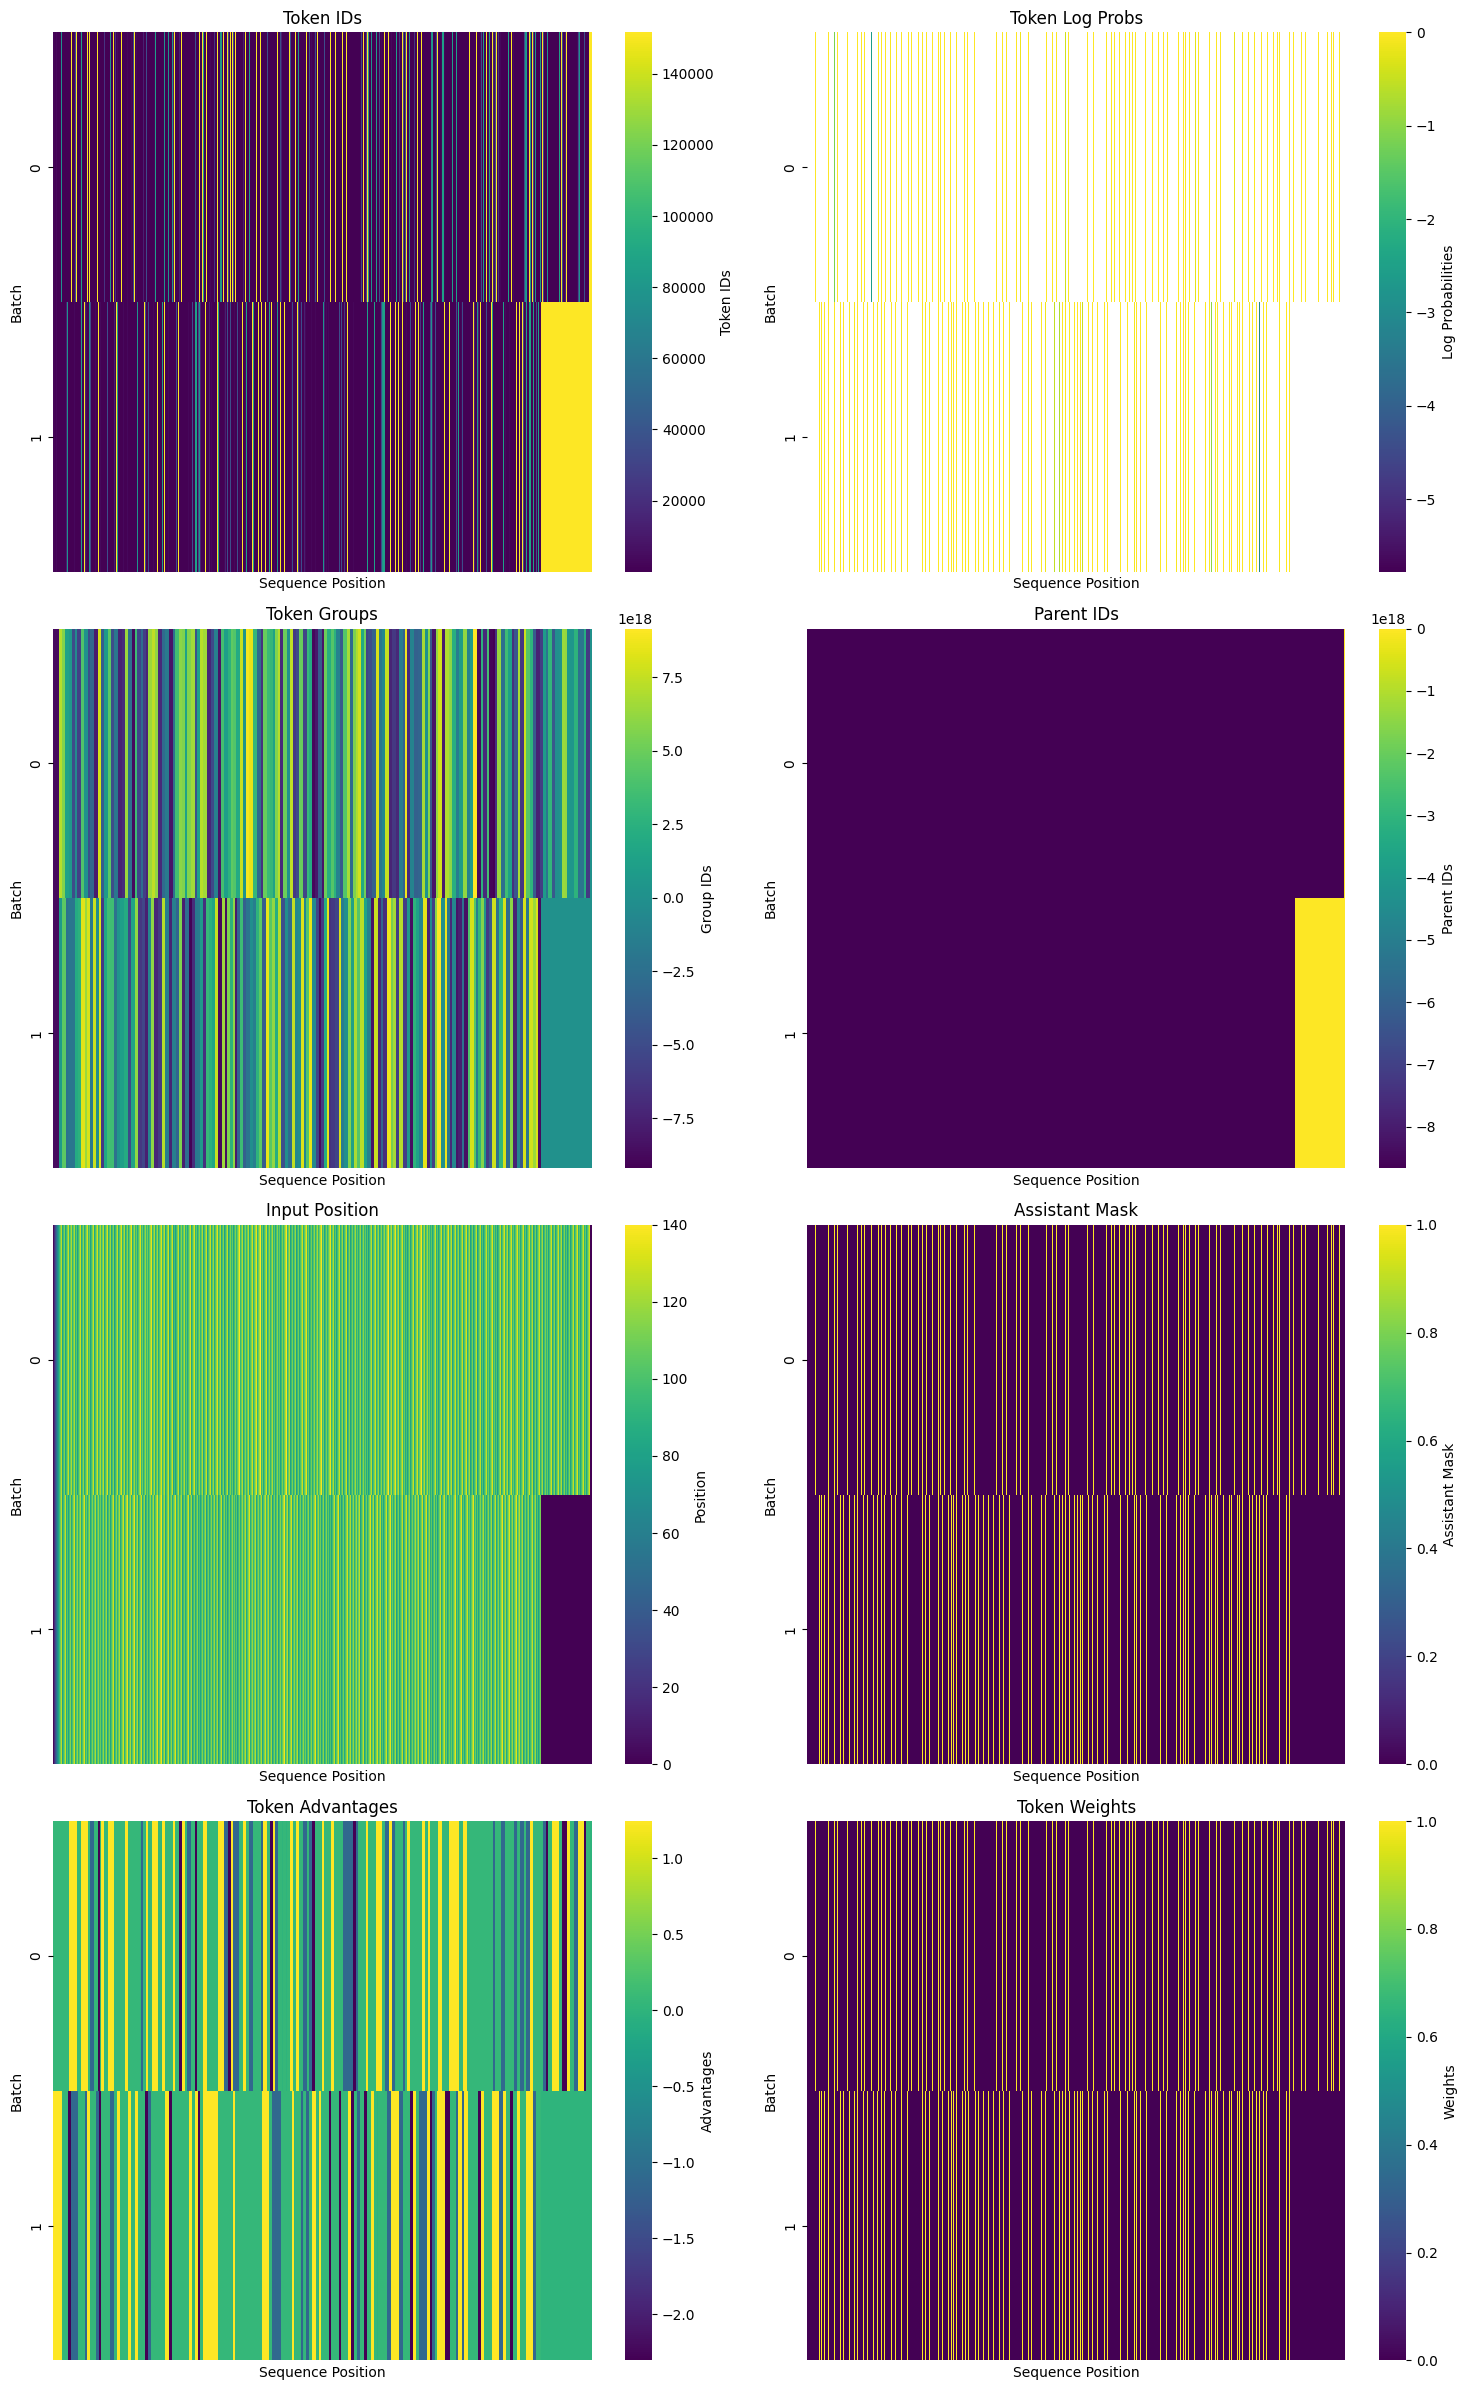

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0003


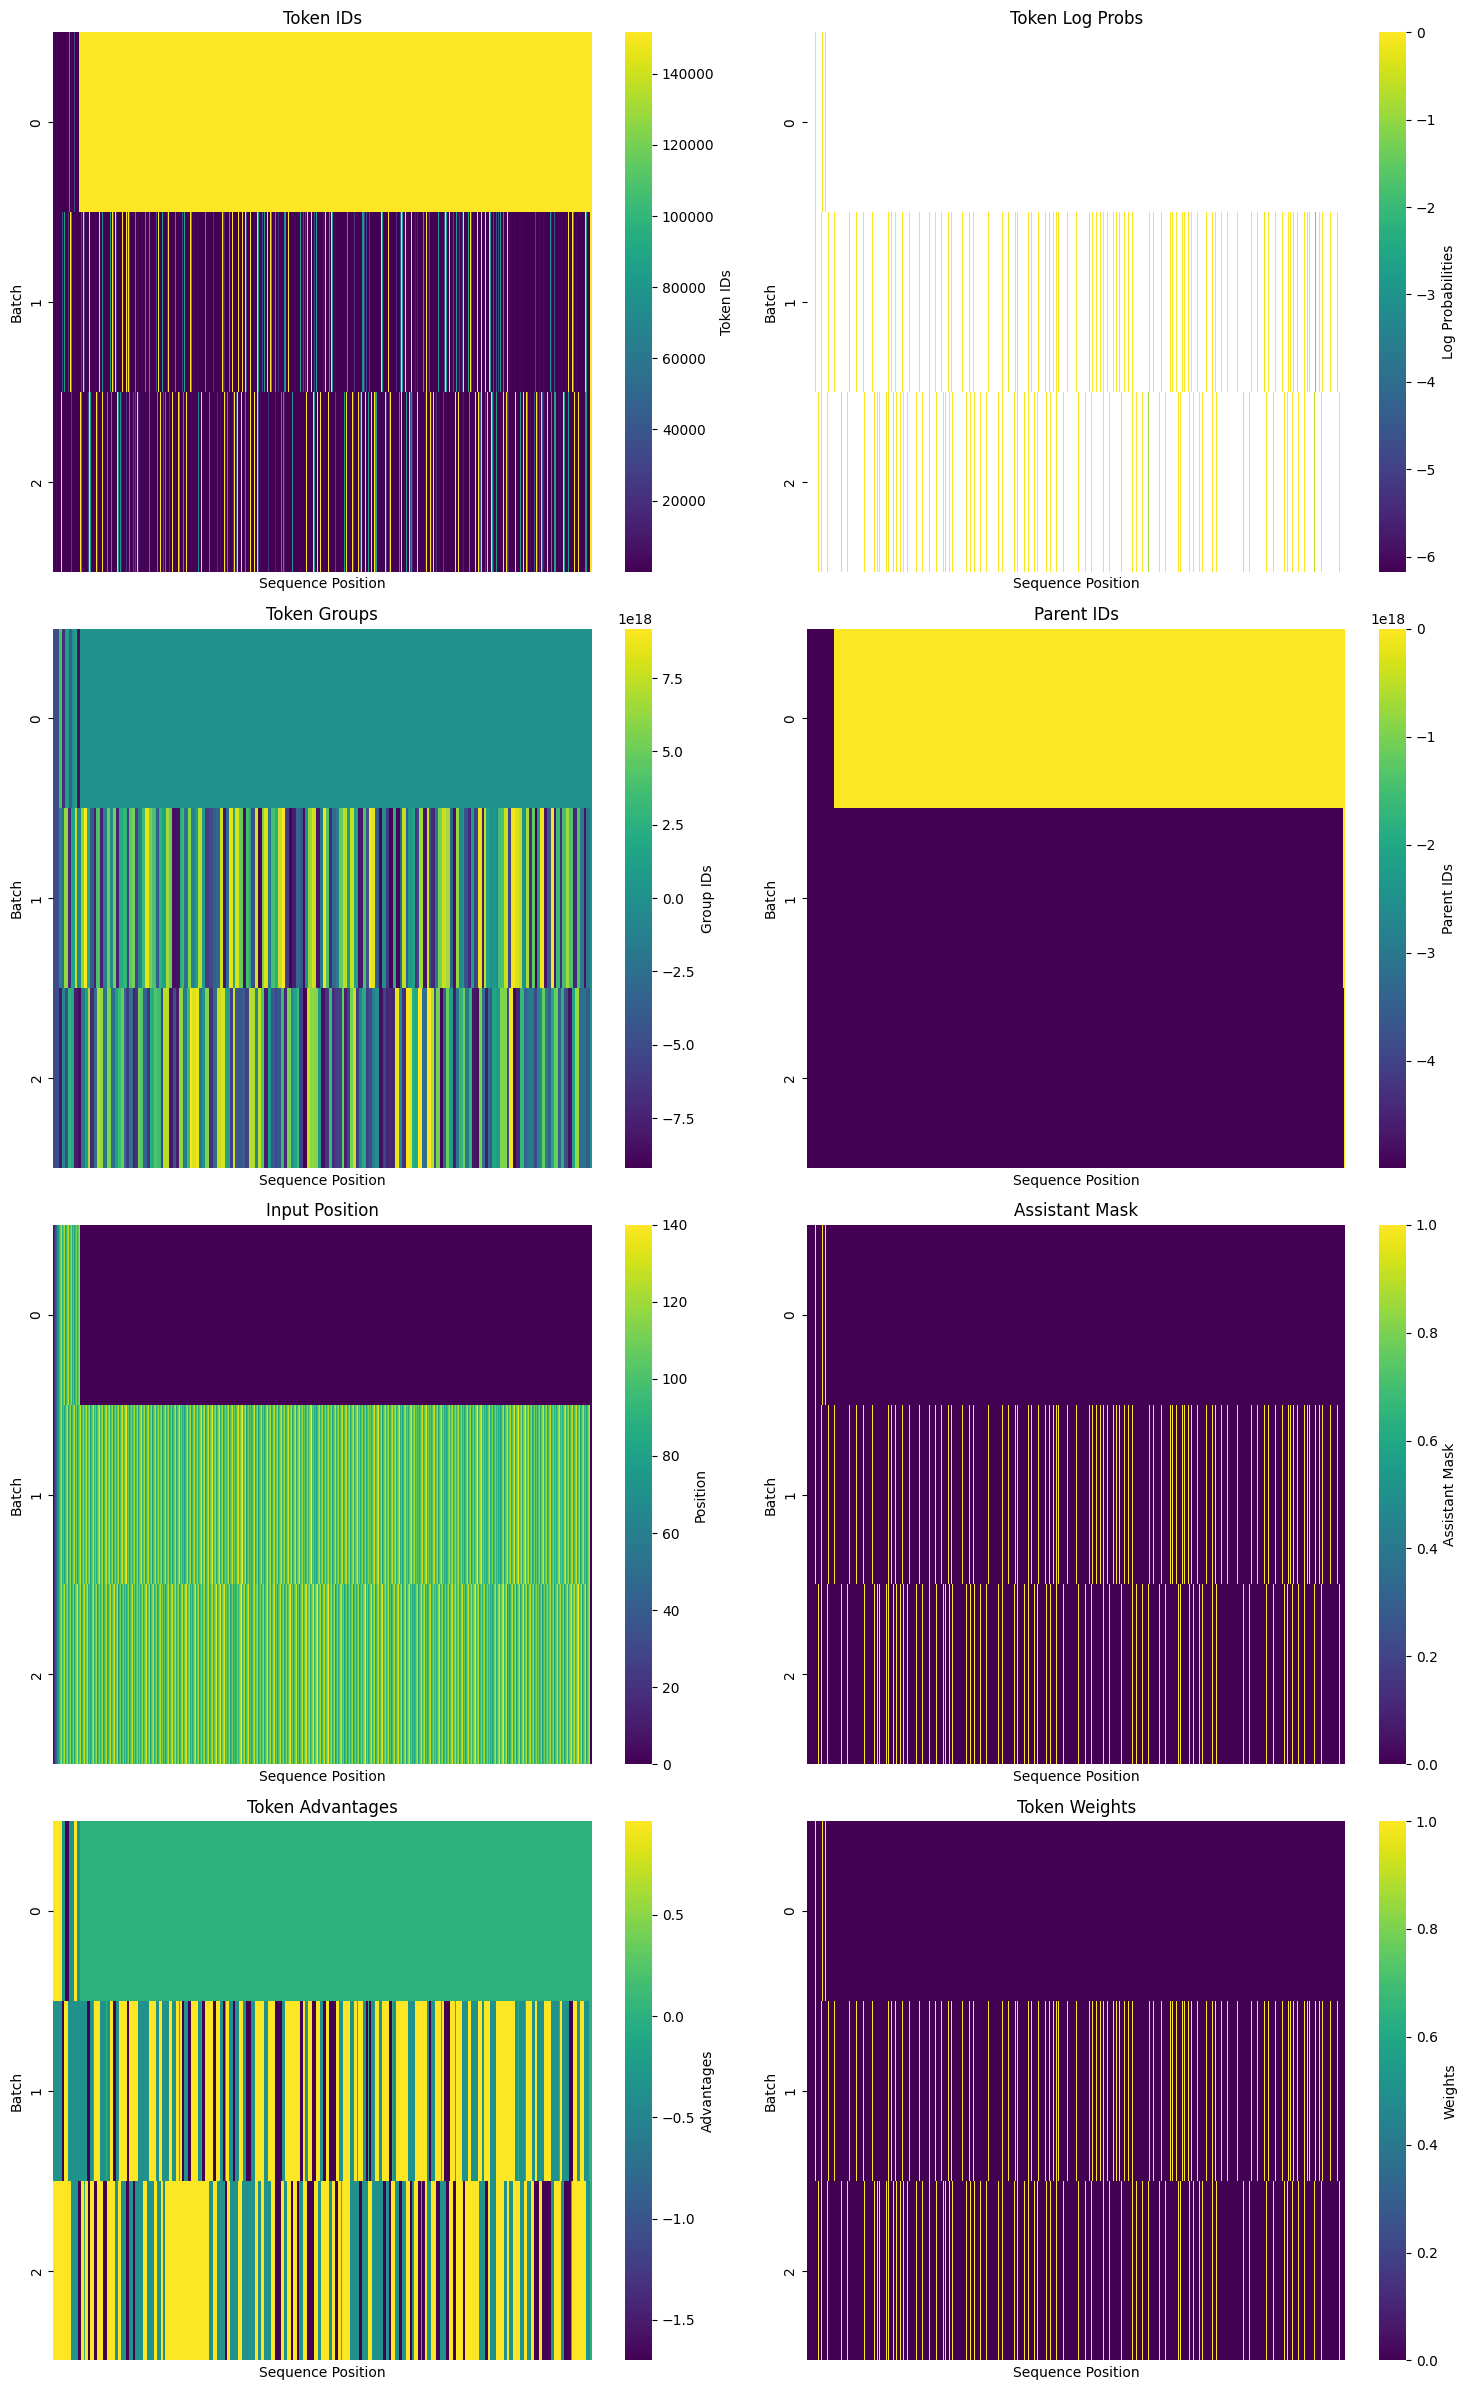

tune:   0%|          | 0/3 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0004


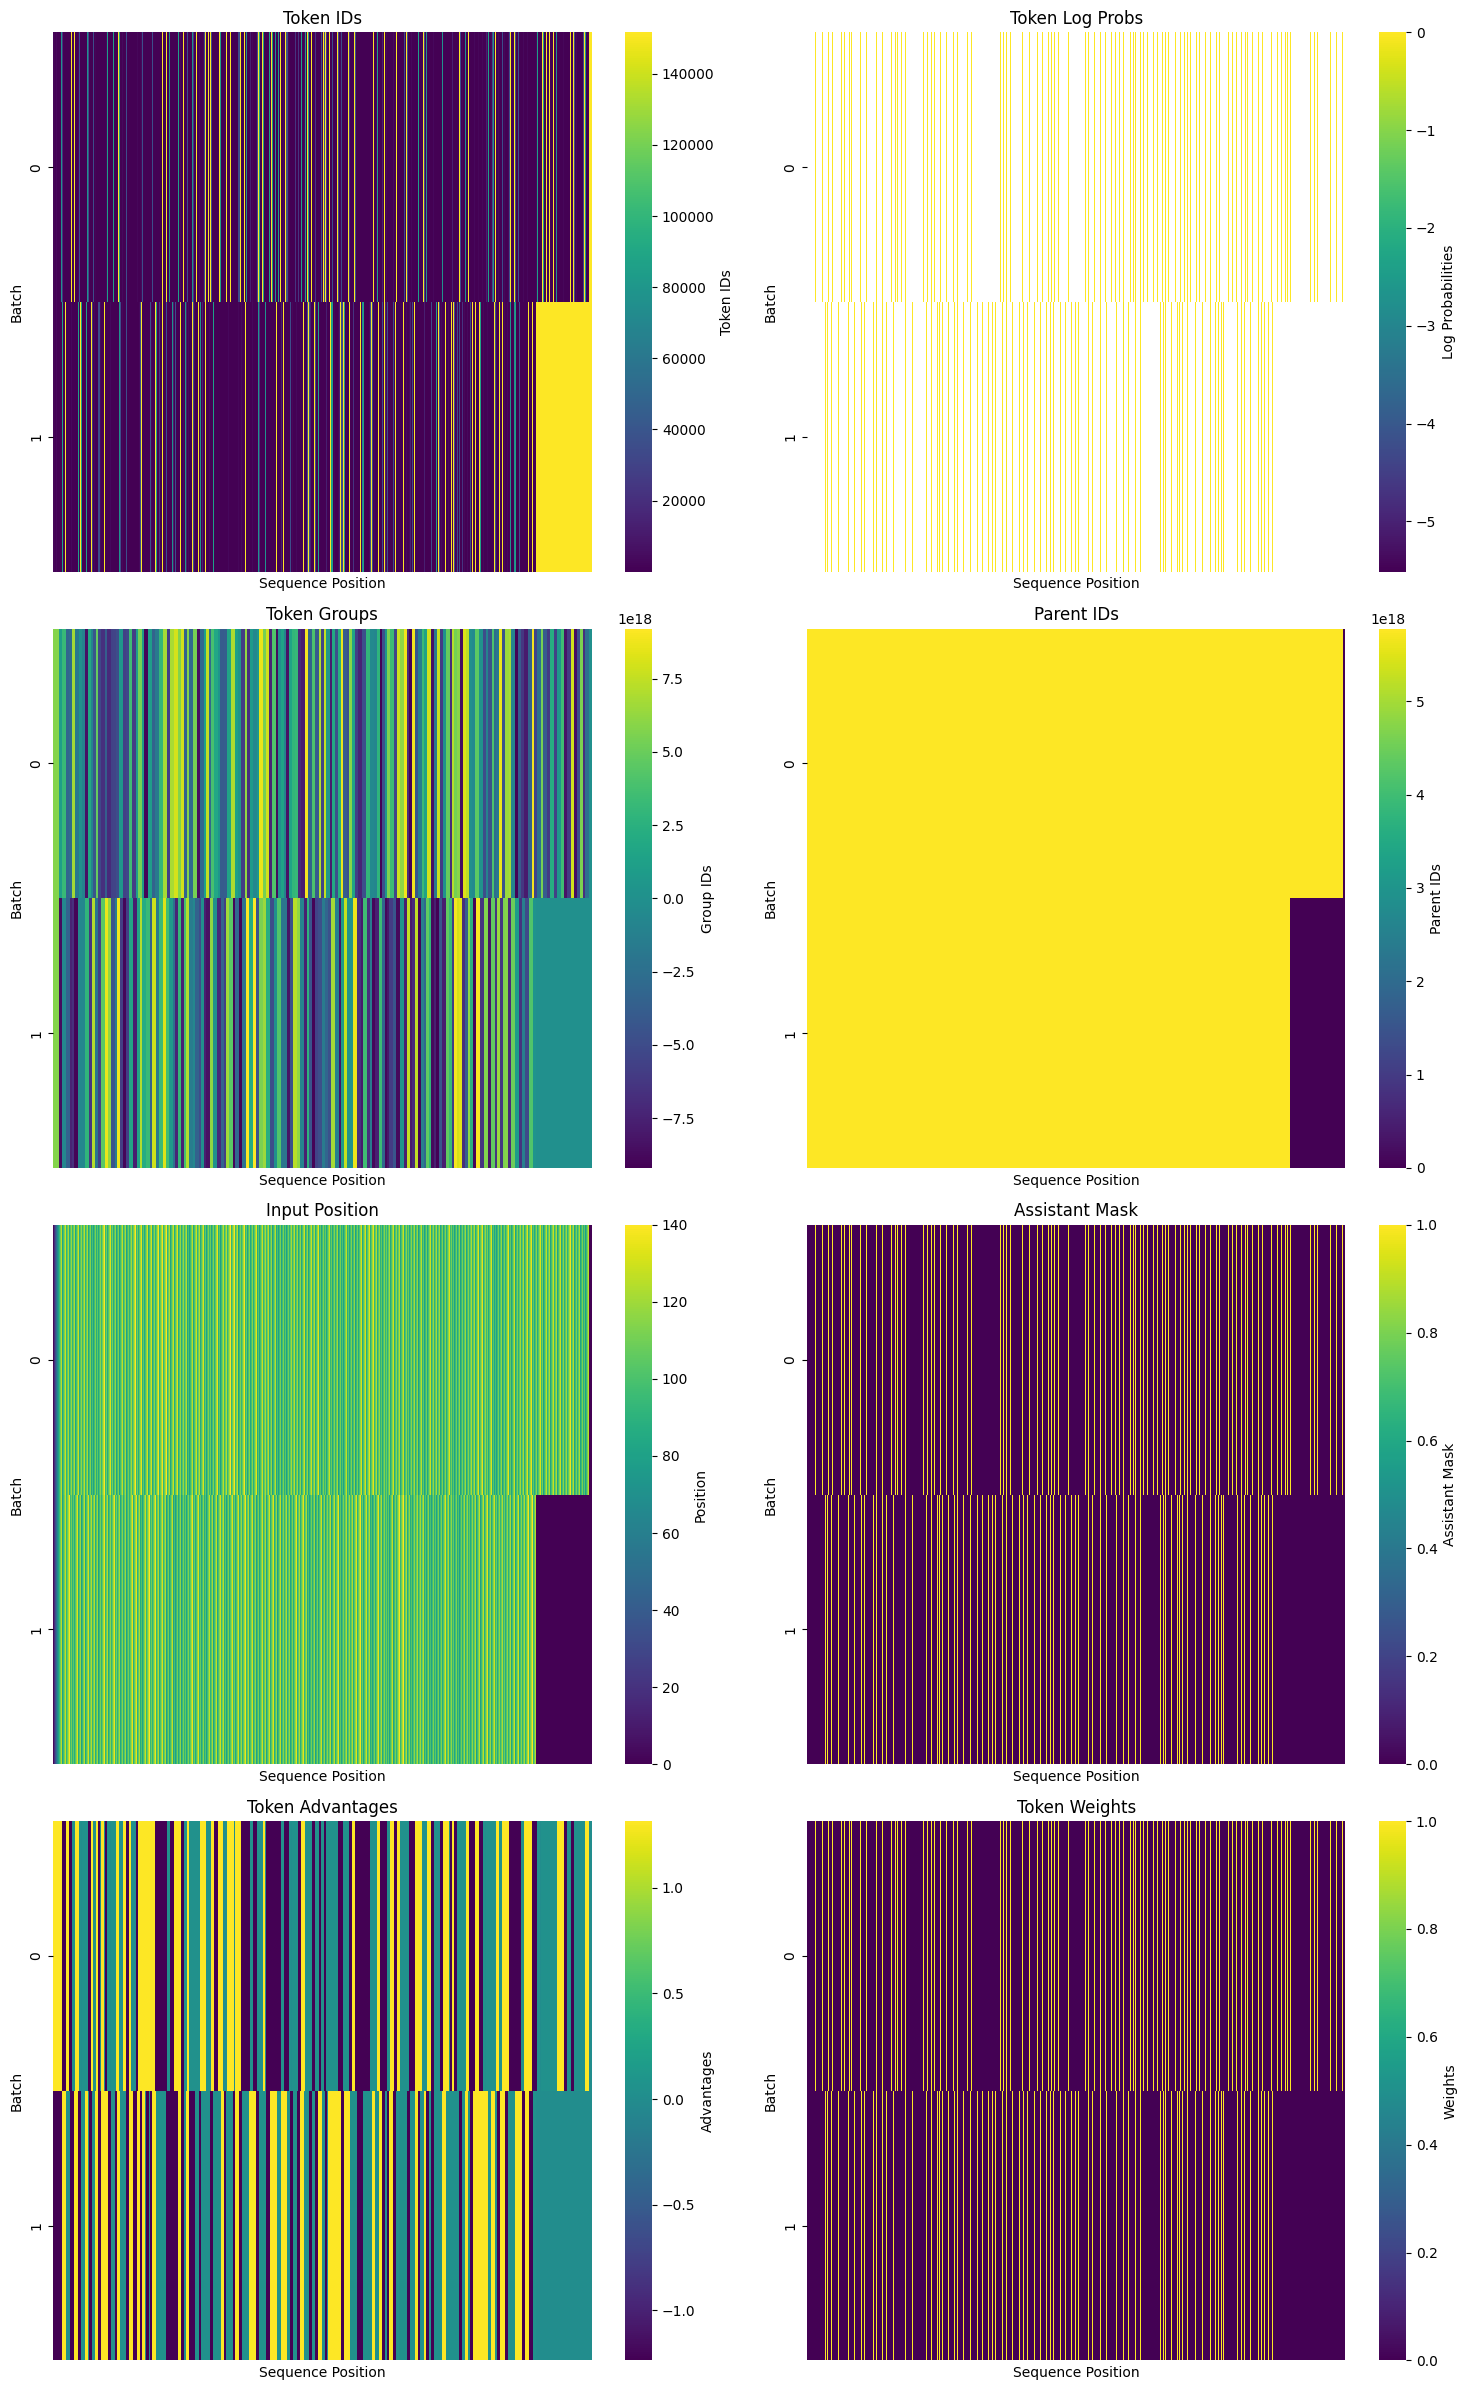

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0005


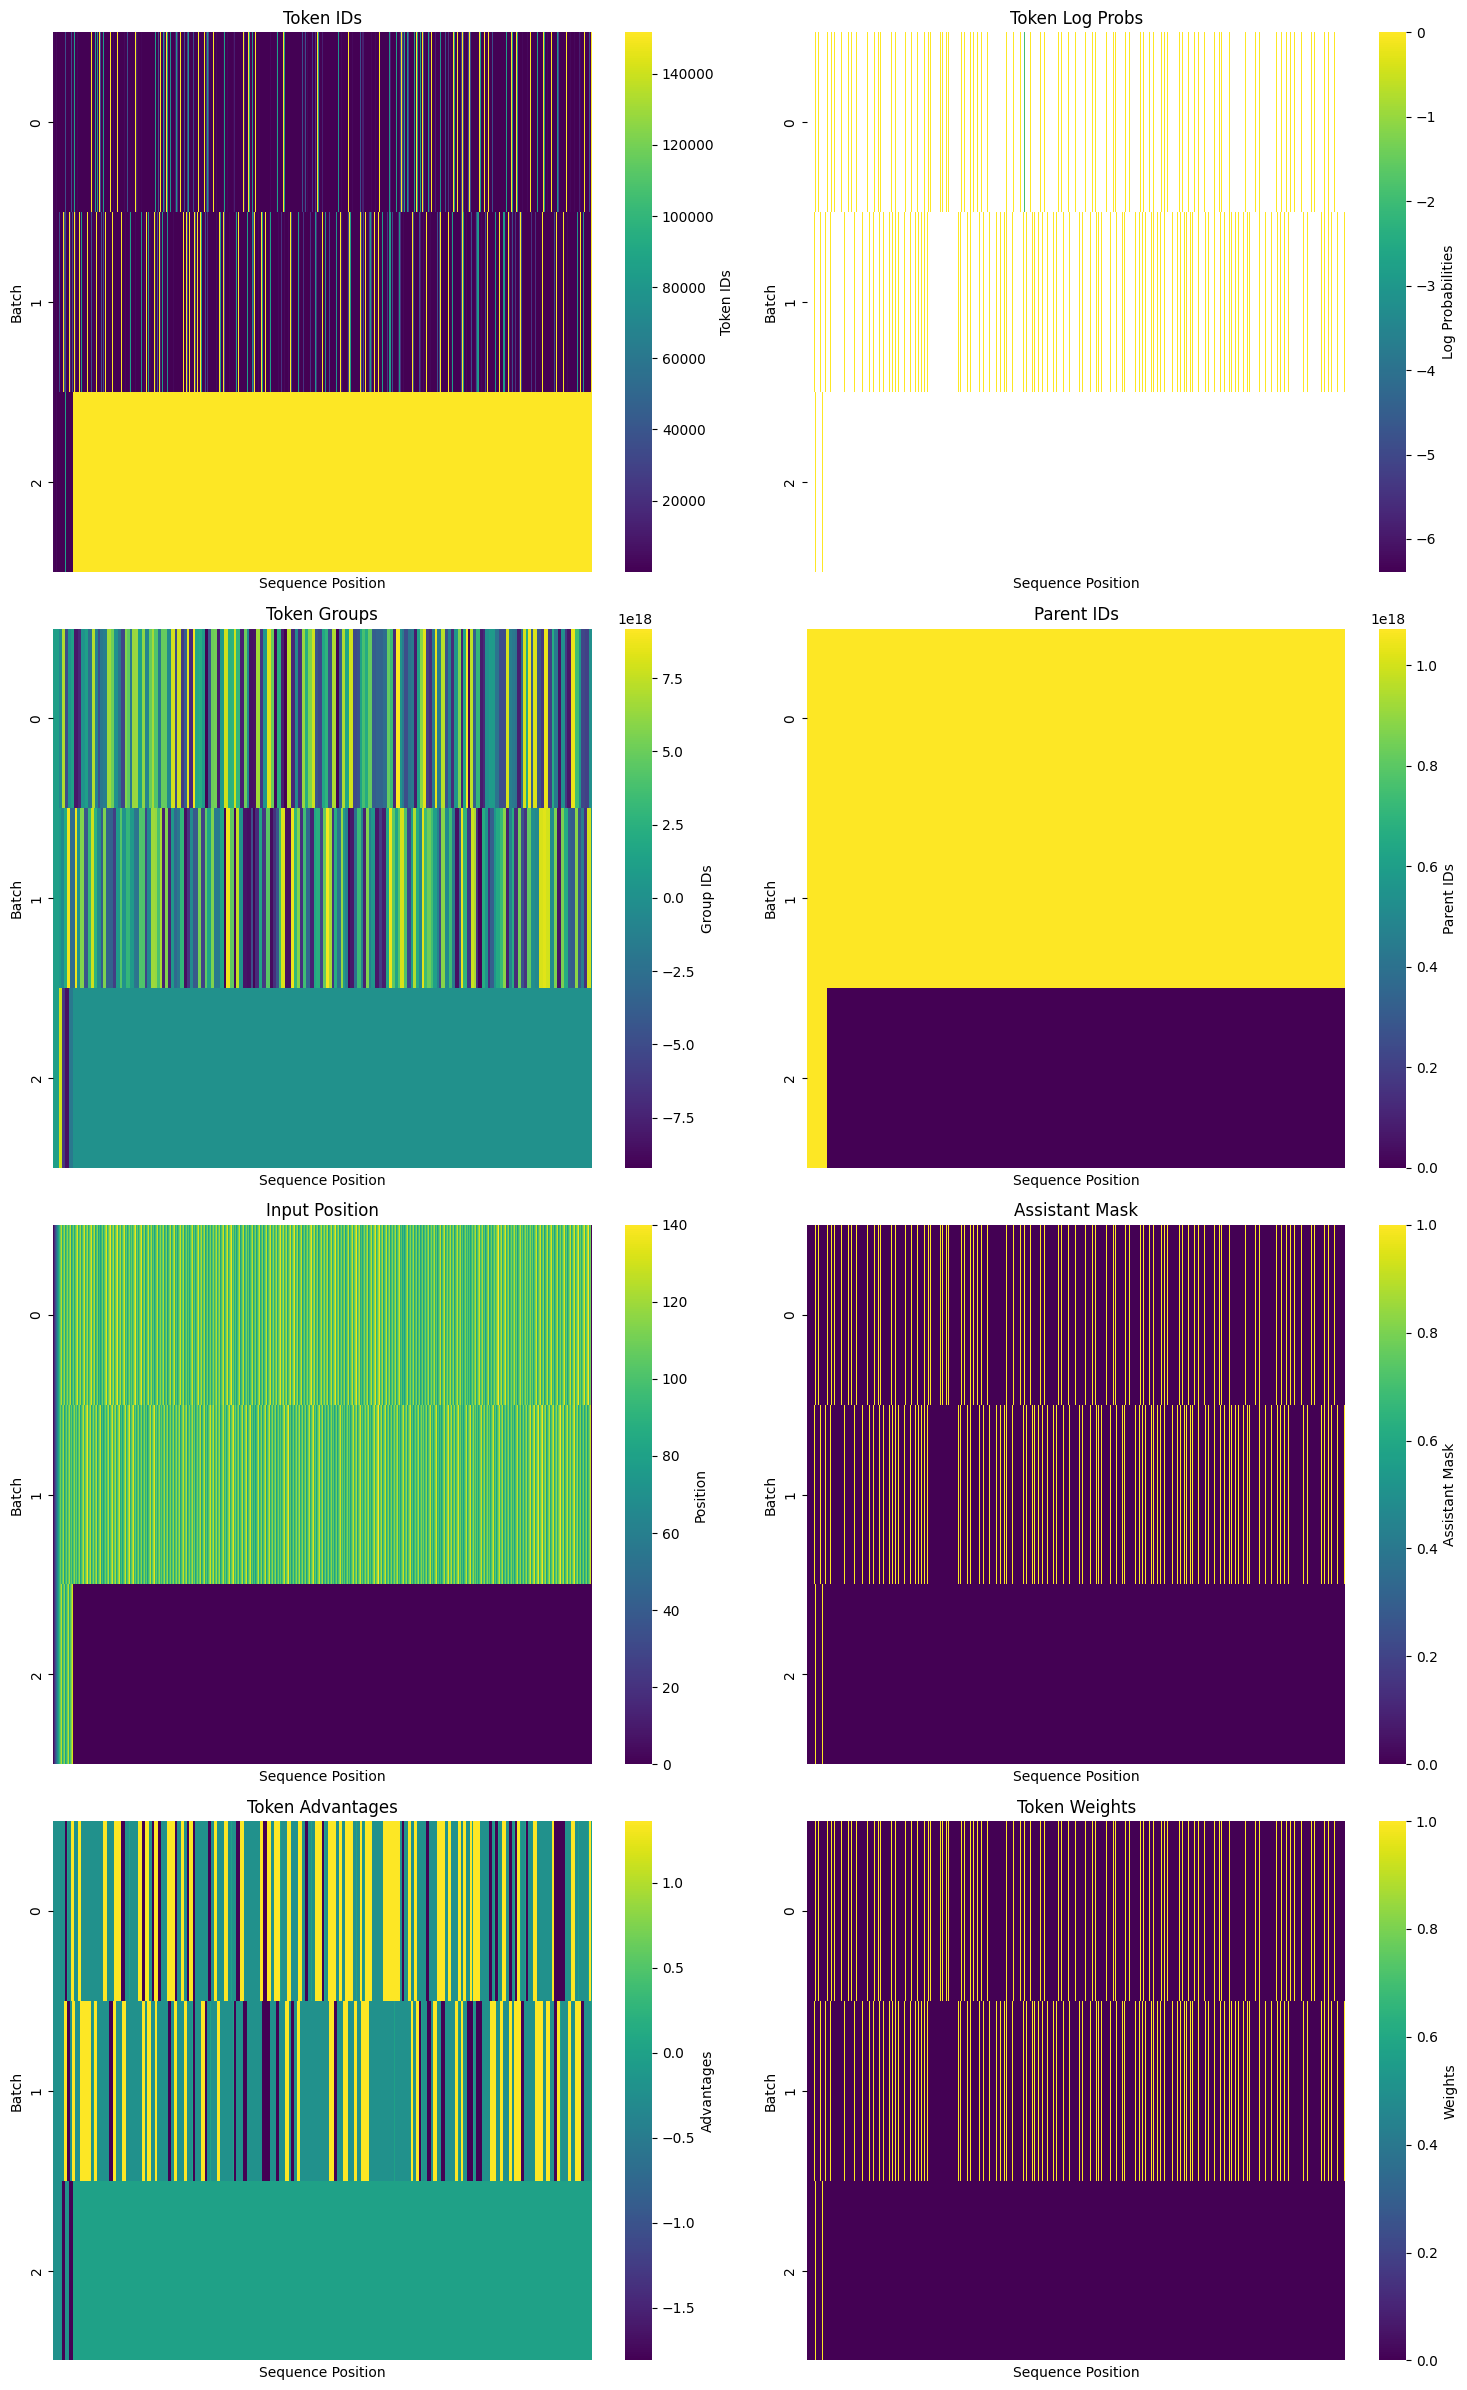

tune:   0%|          | 0/3 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0006


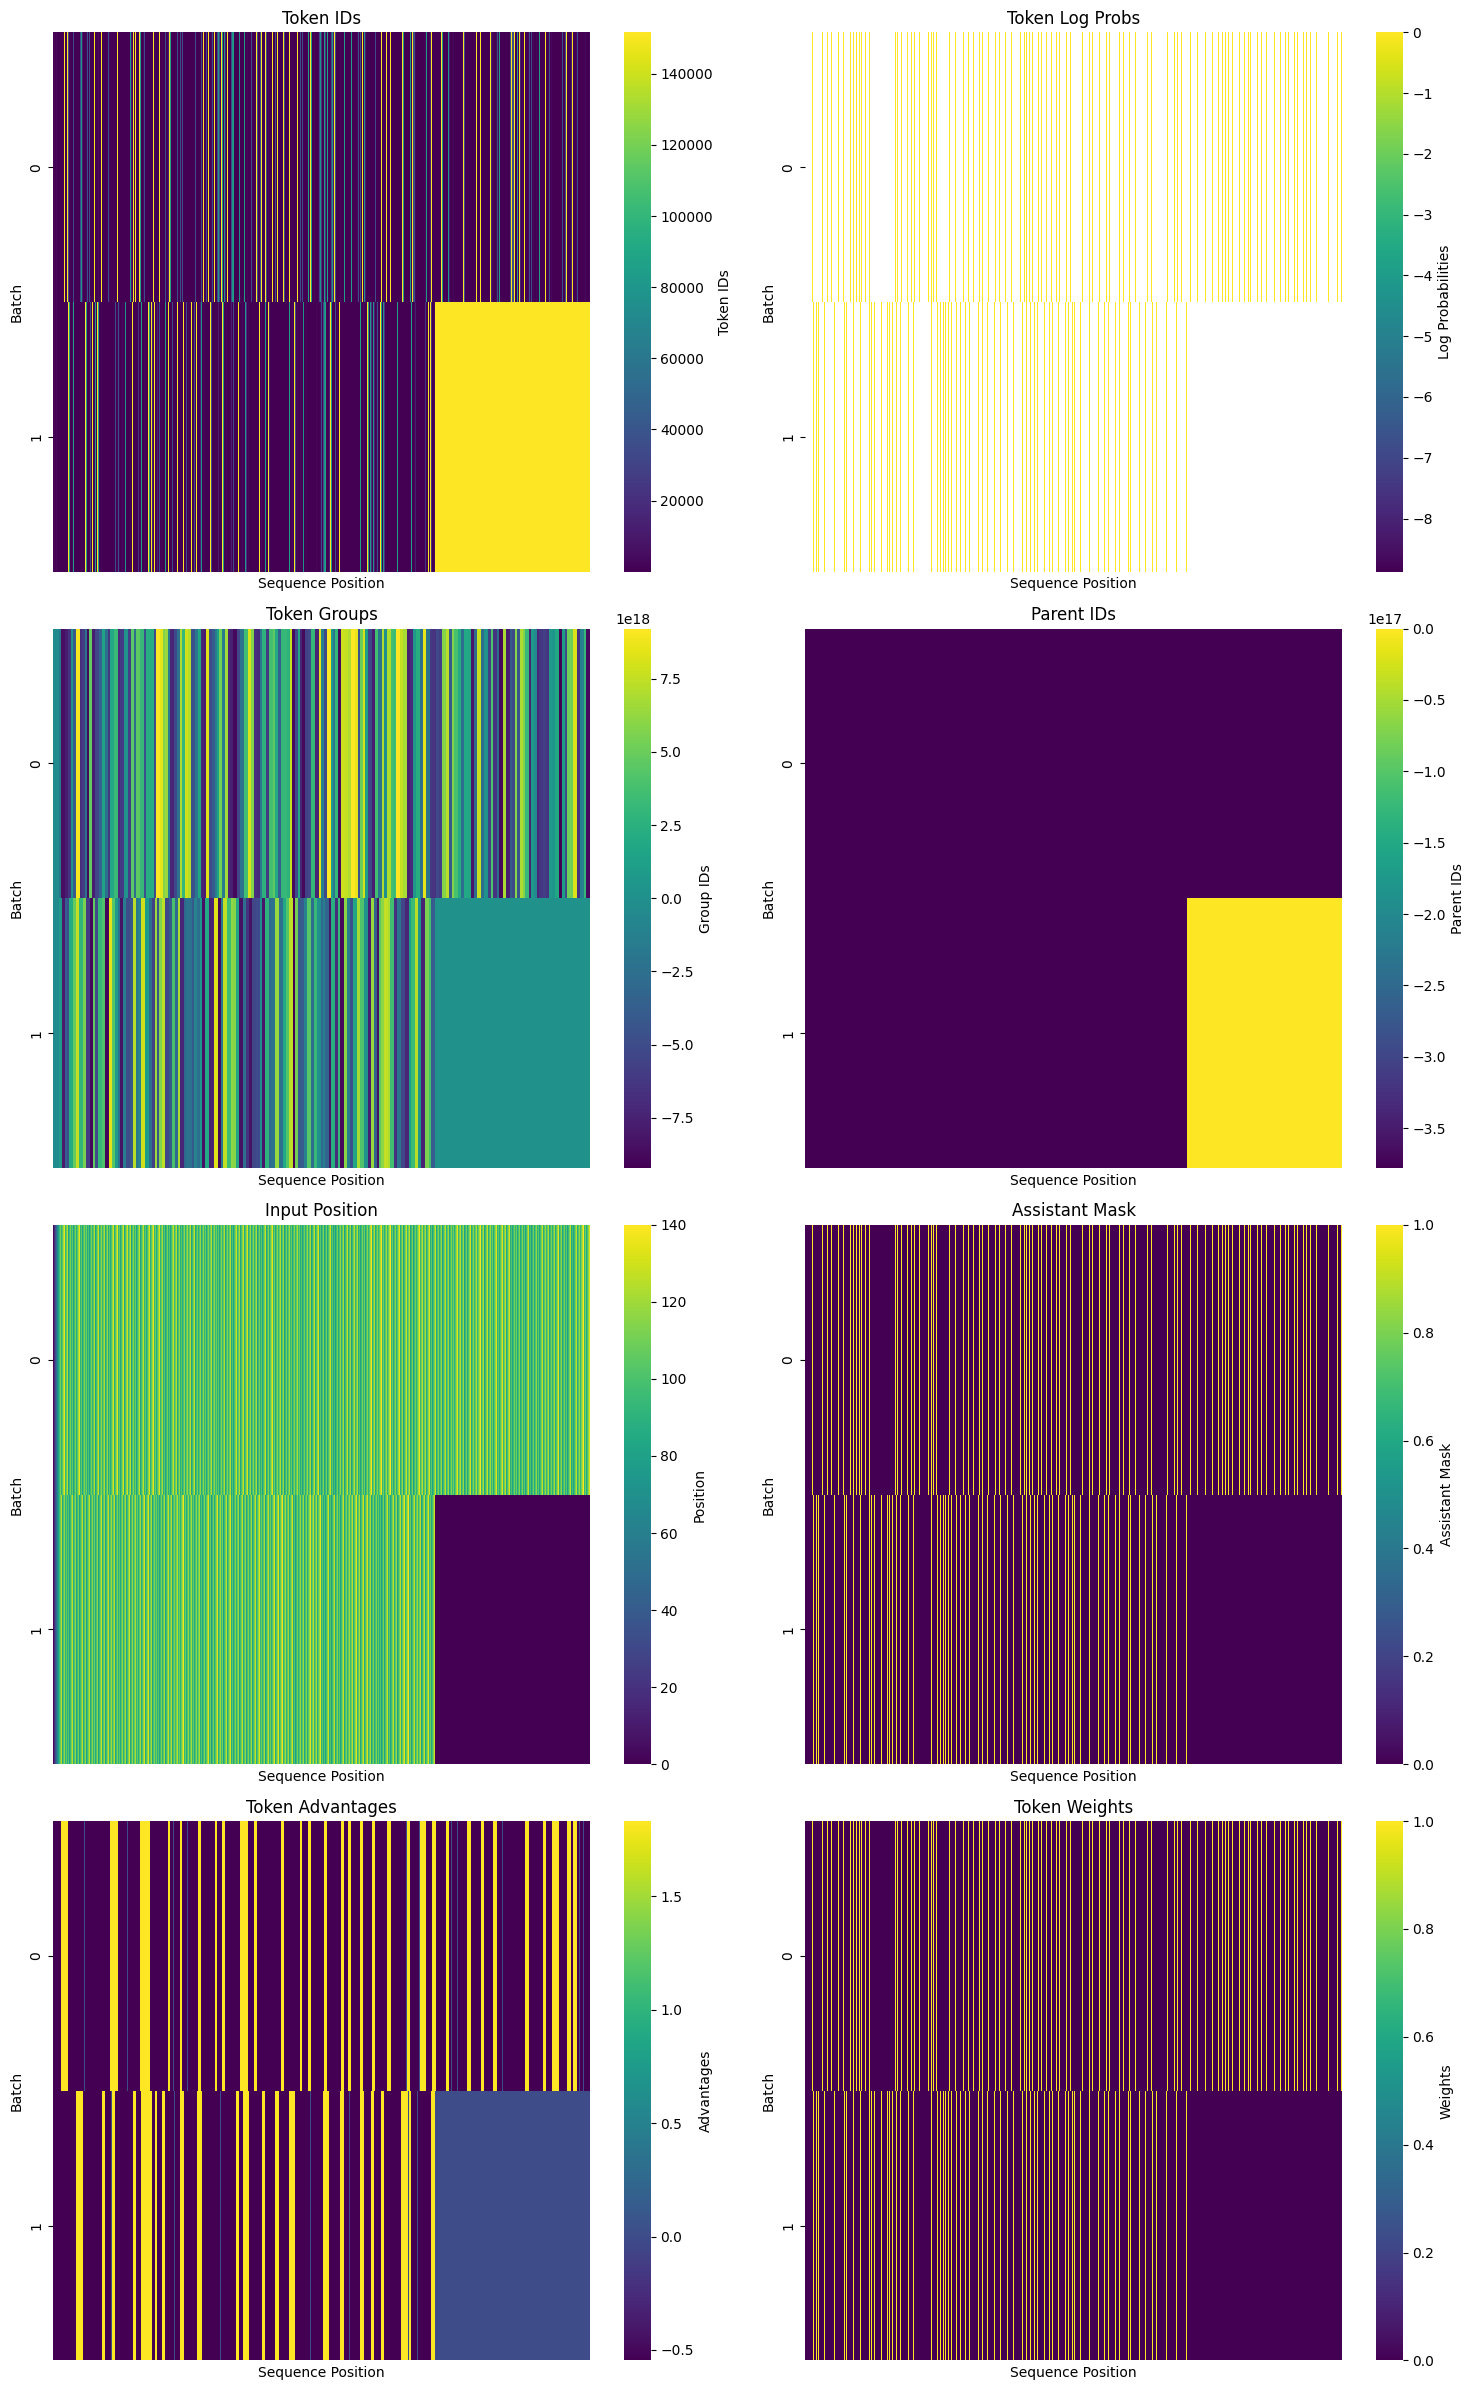

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0007


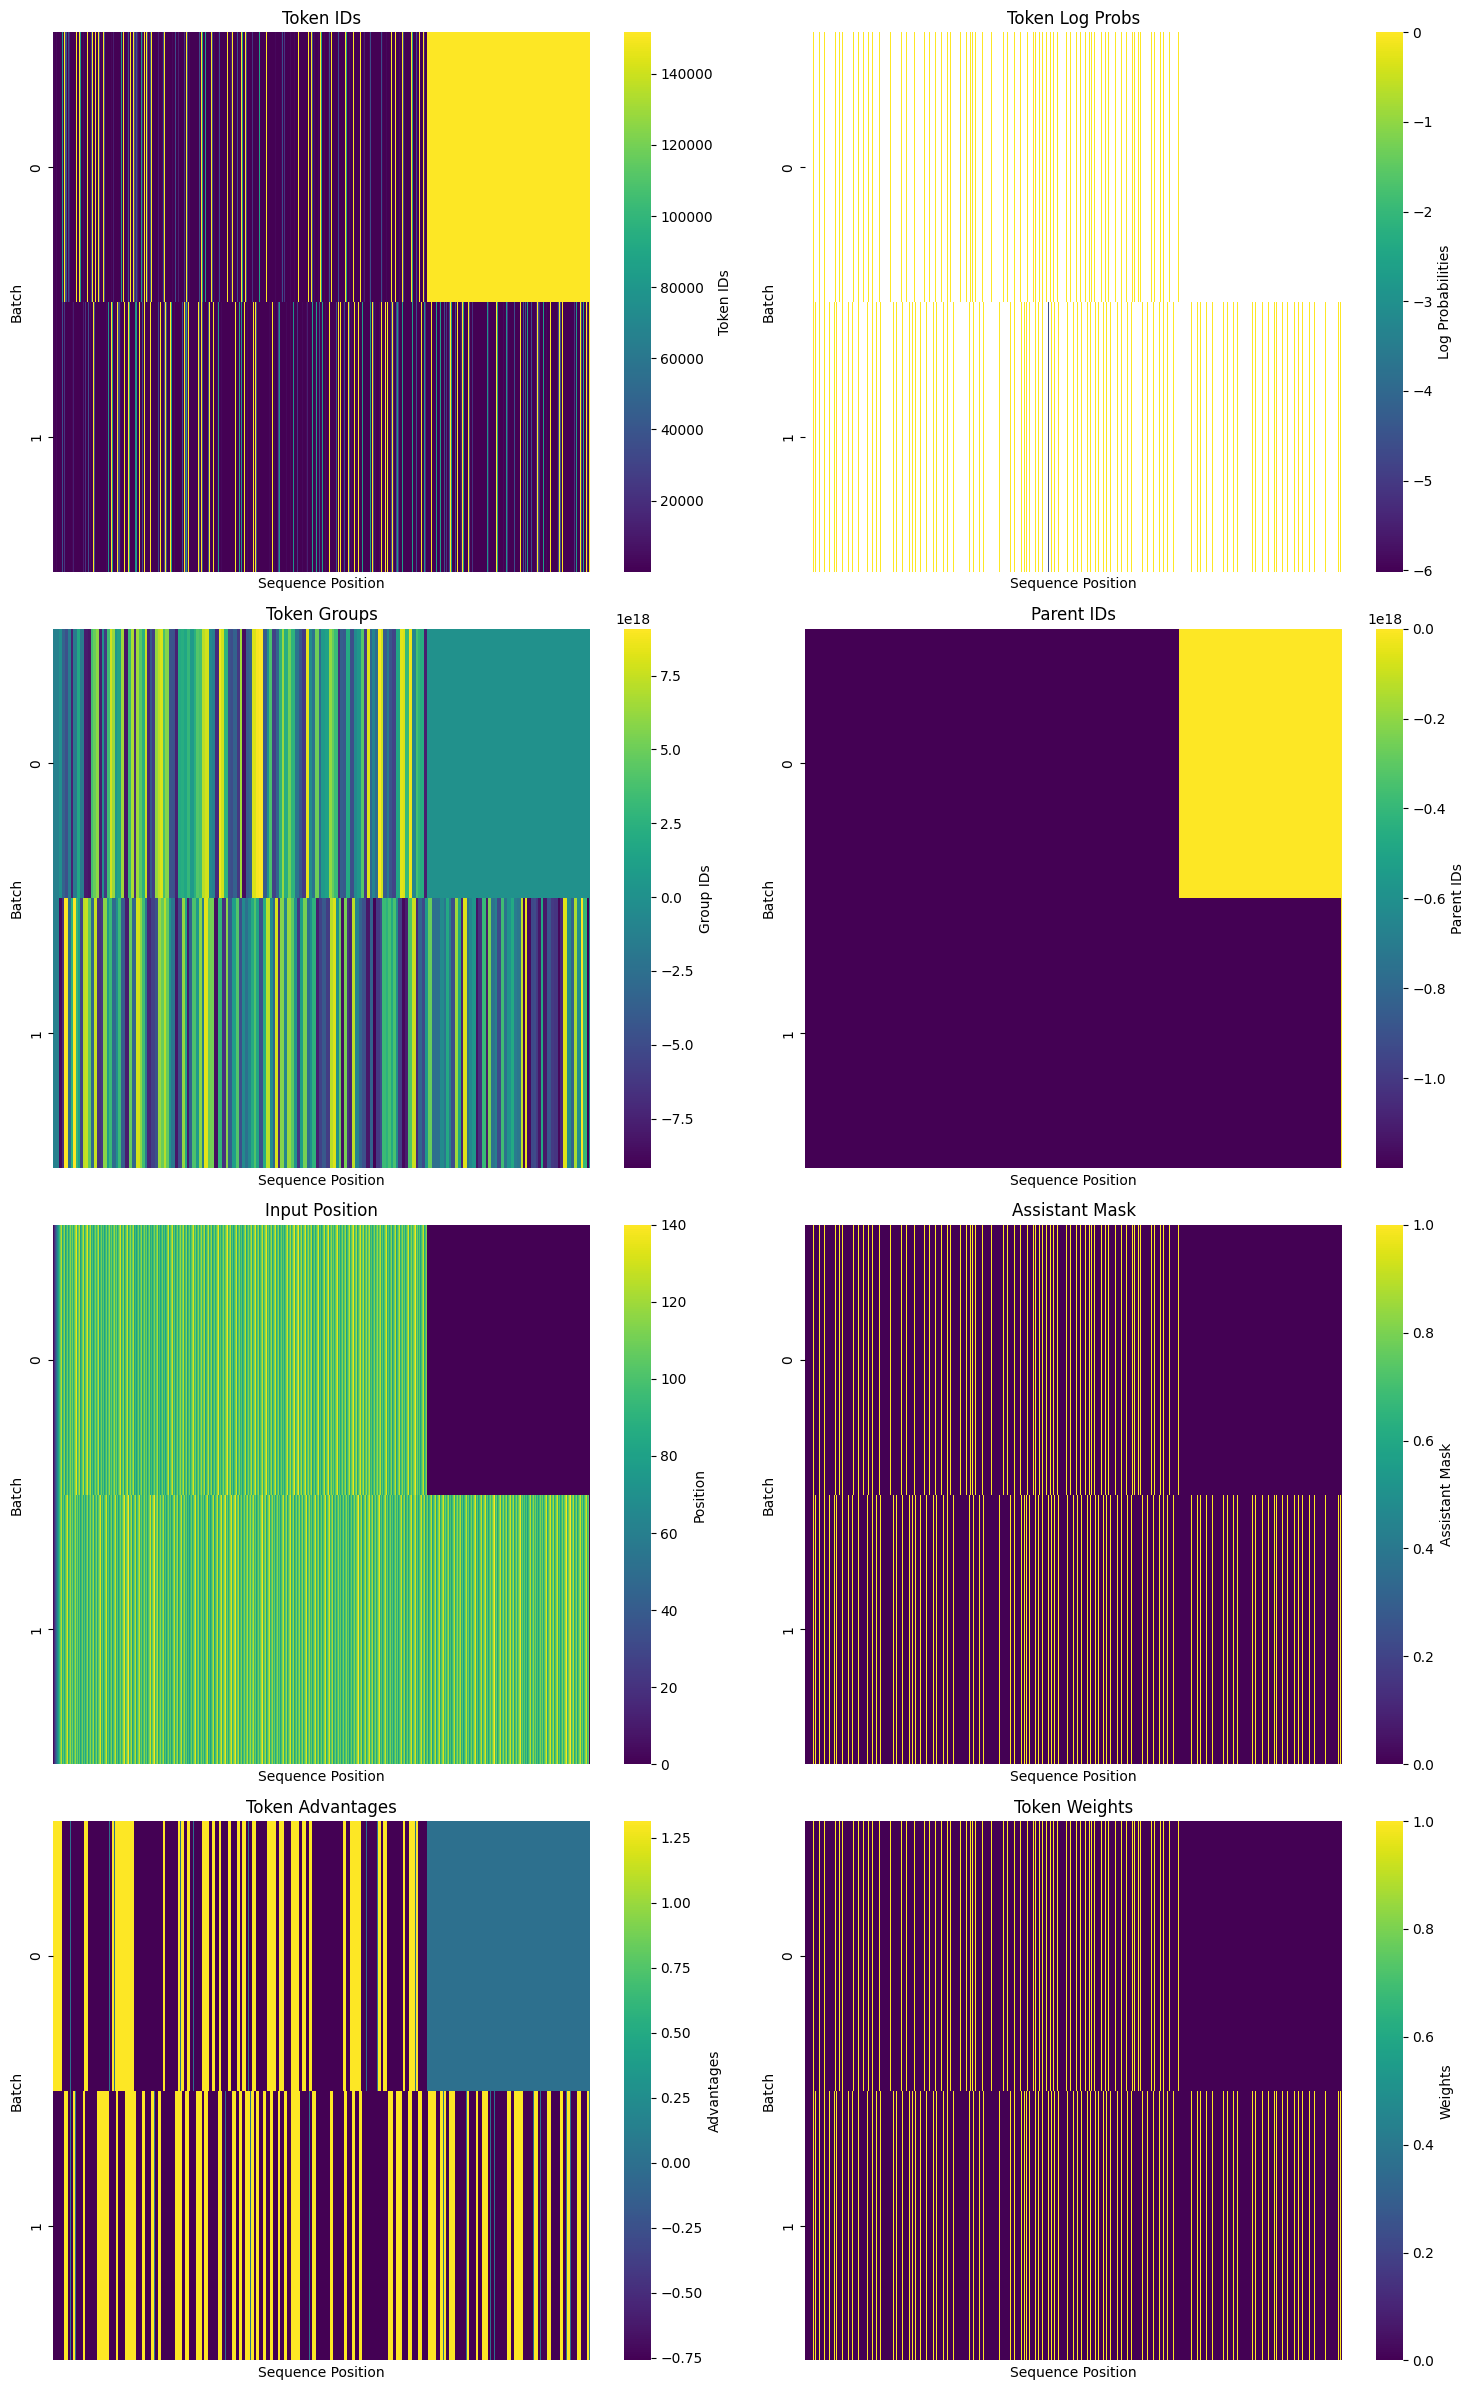

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0008


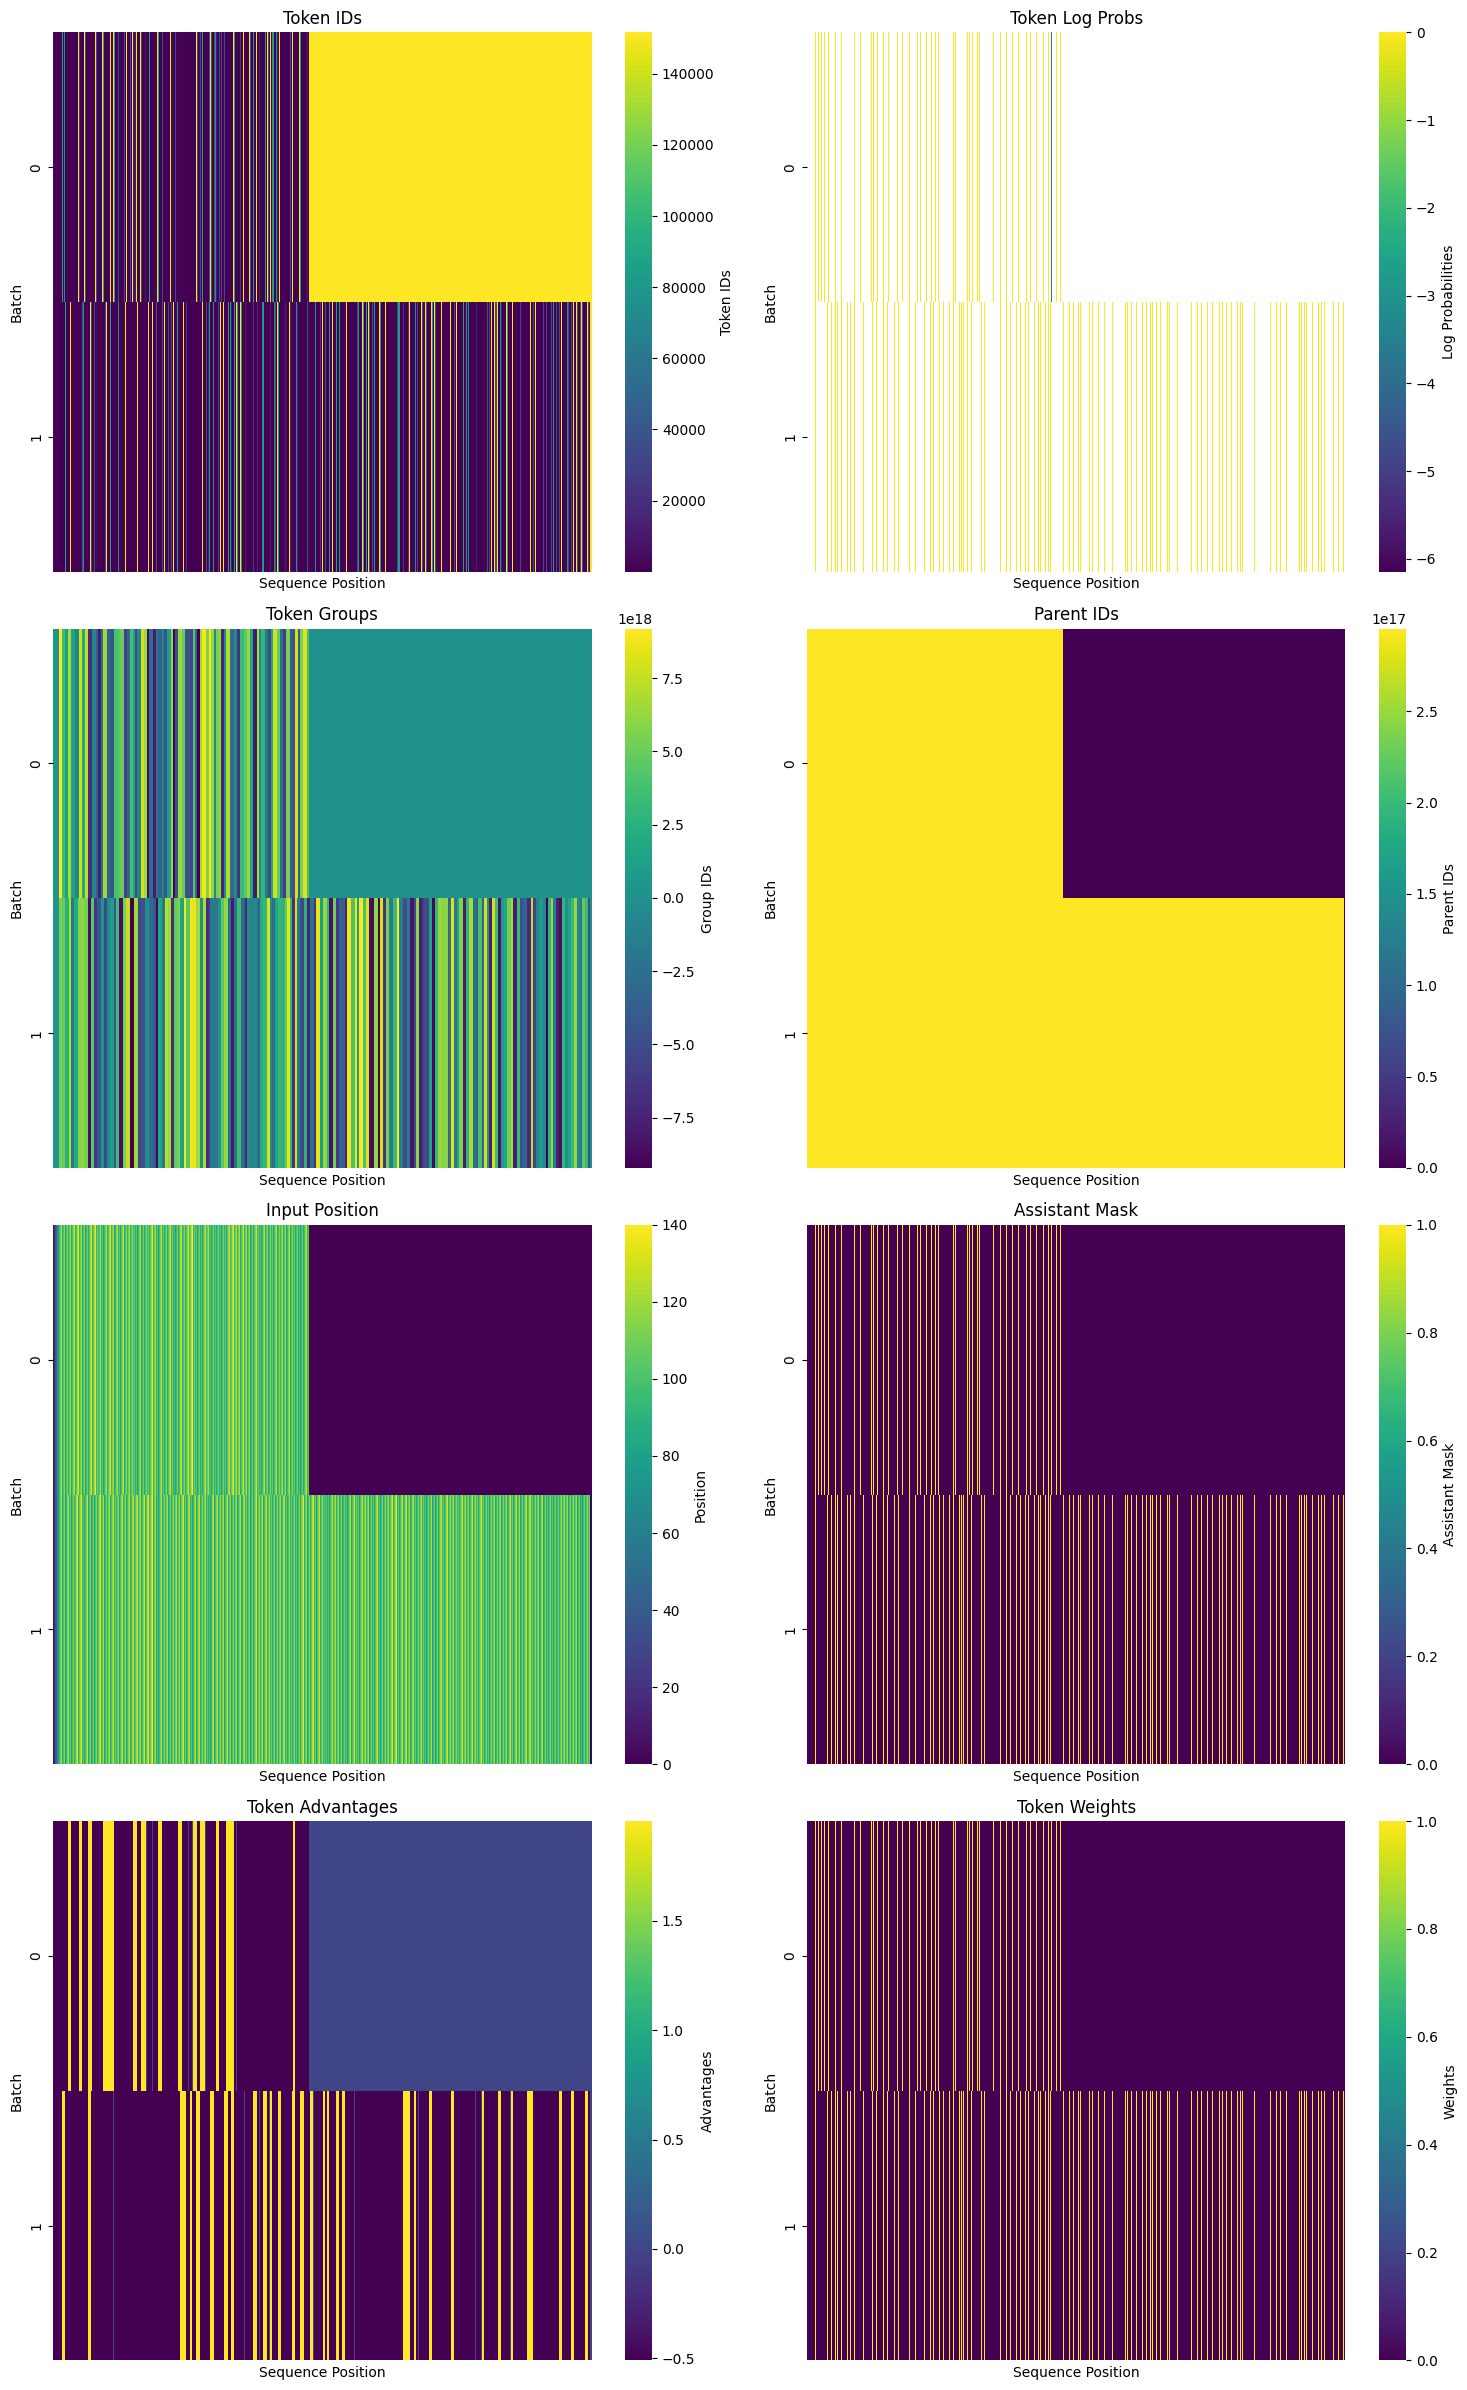

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0009


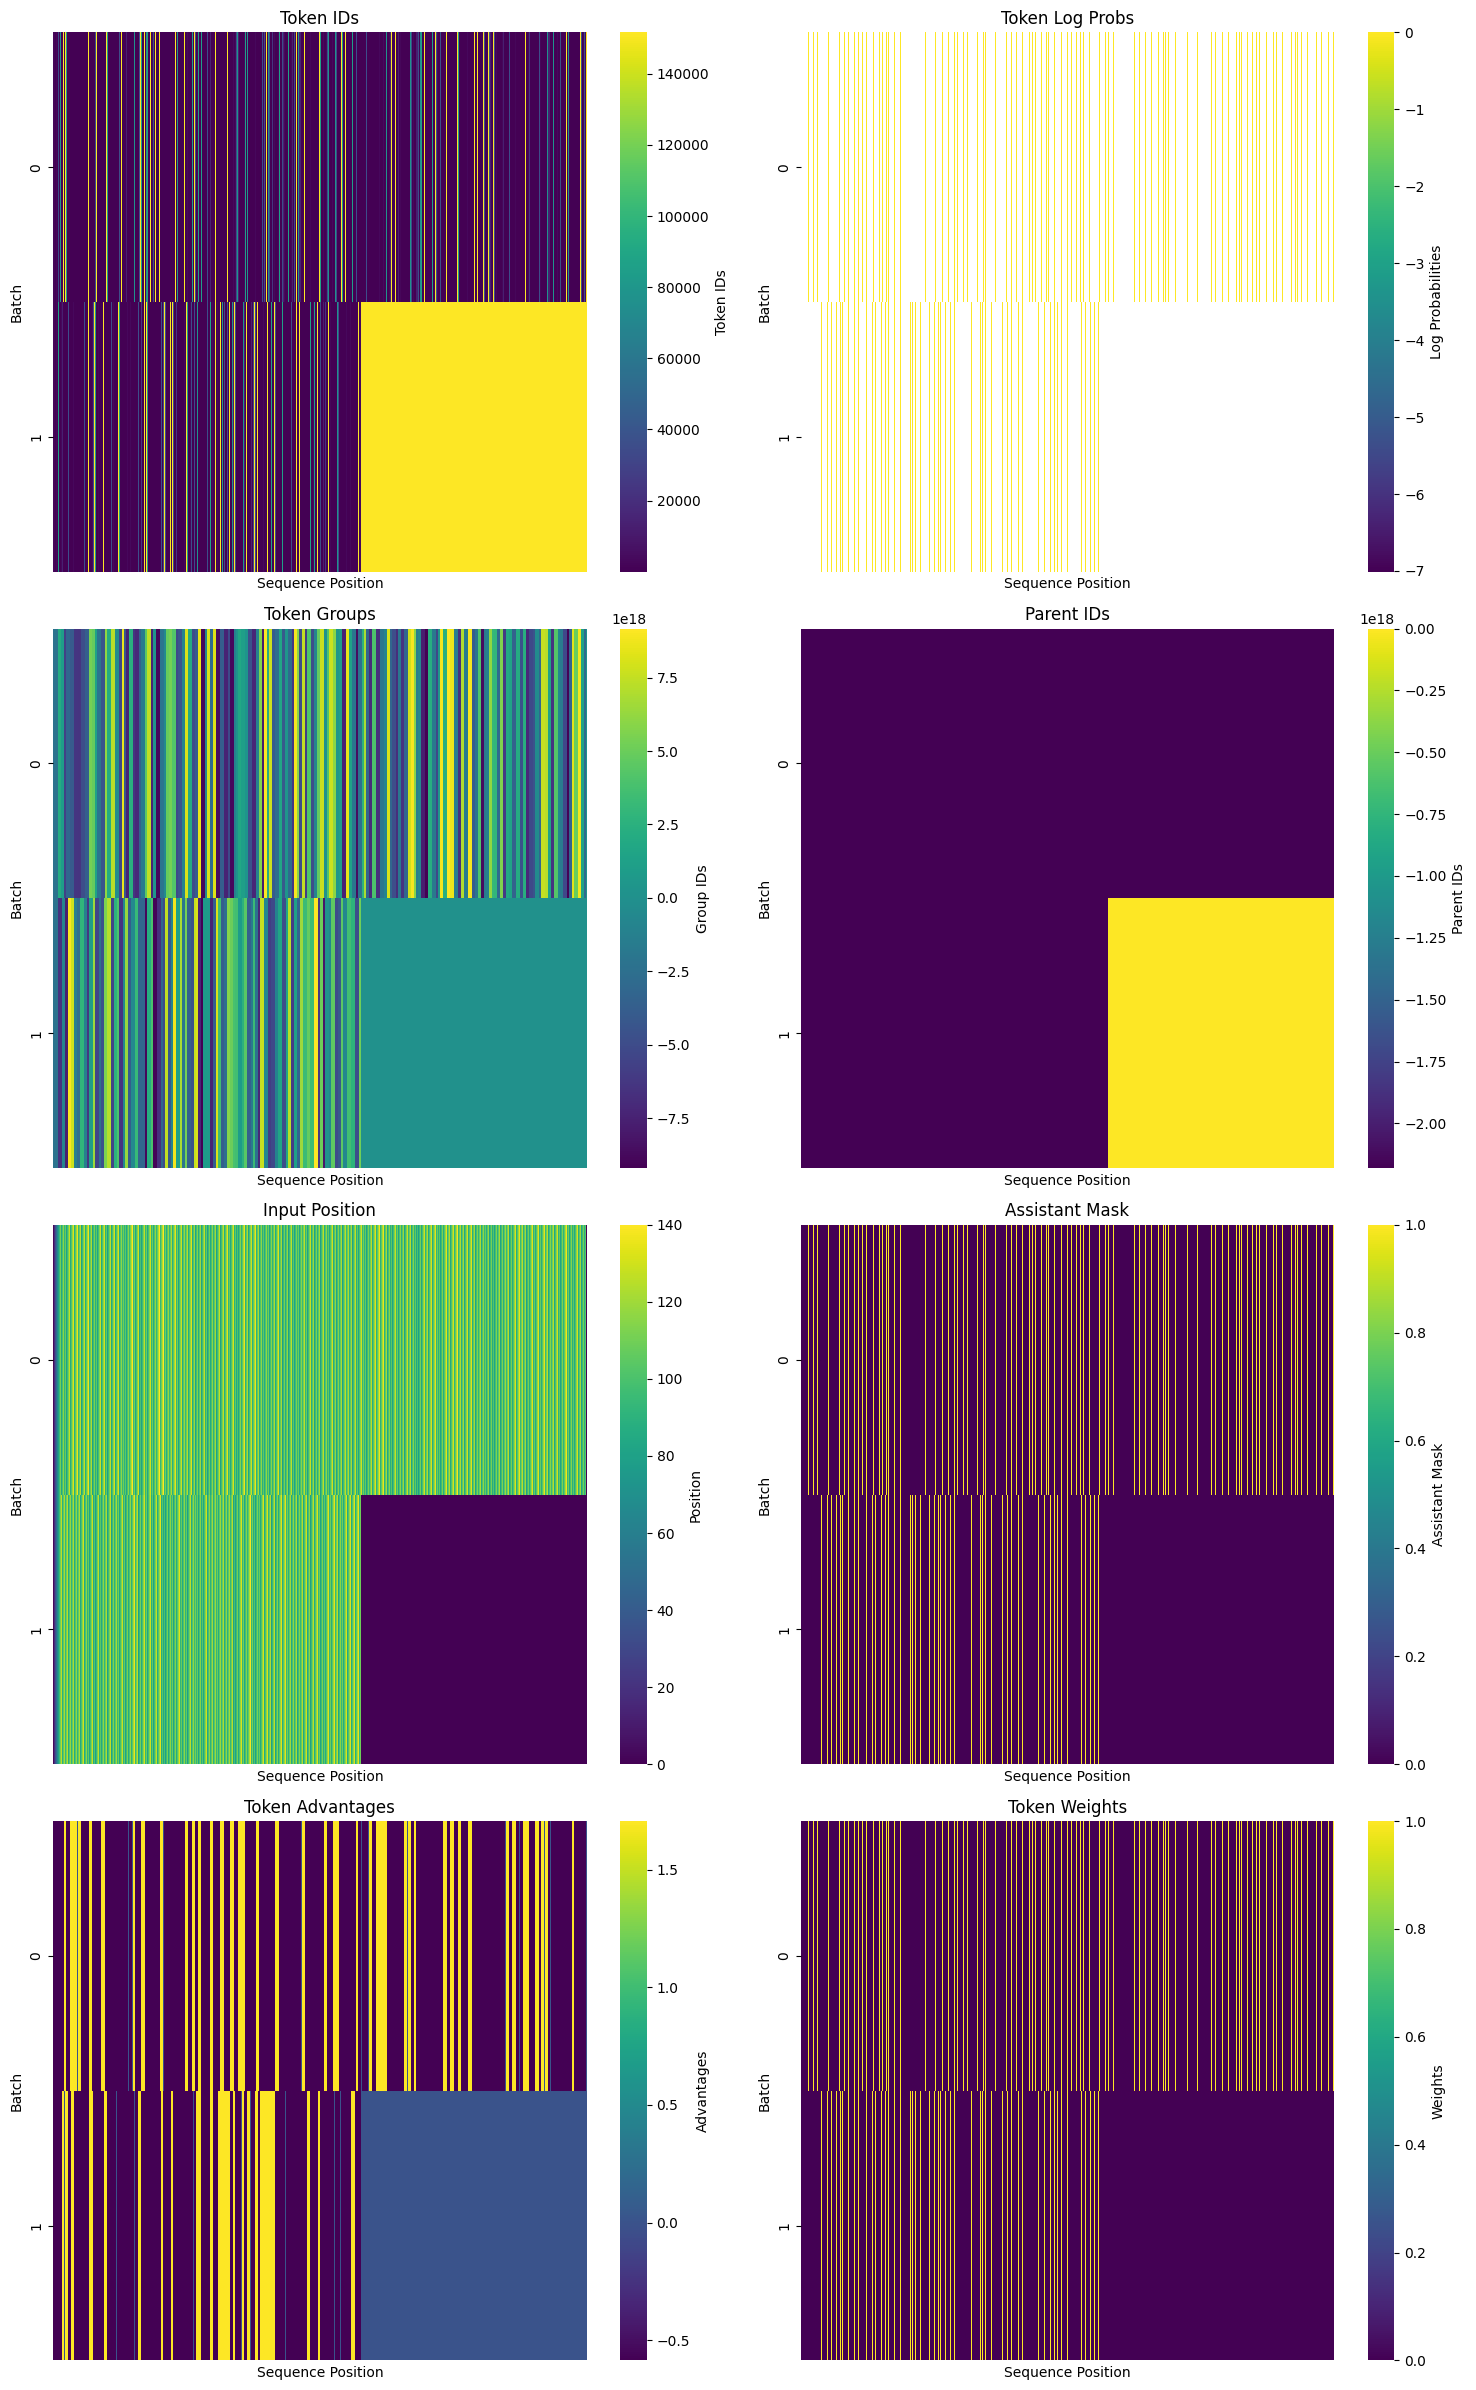

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0010
Skipping tuning as there is no suitable data.


train:   0%|          | 0/6 [00:00<?, ?it/s]

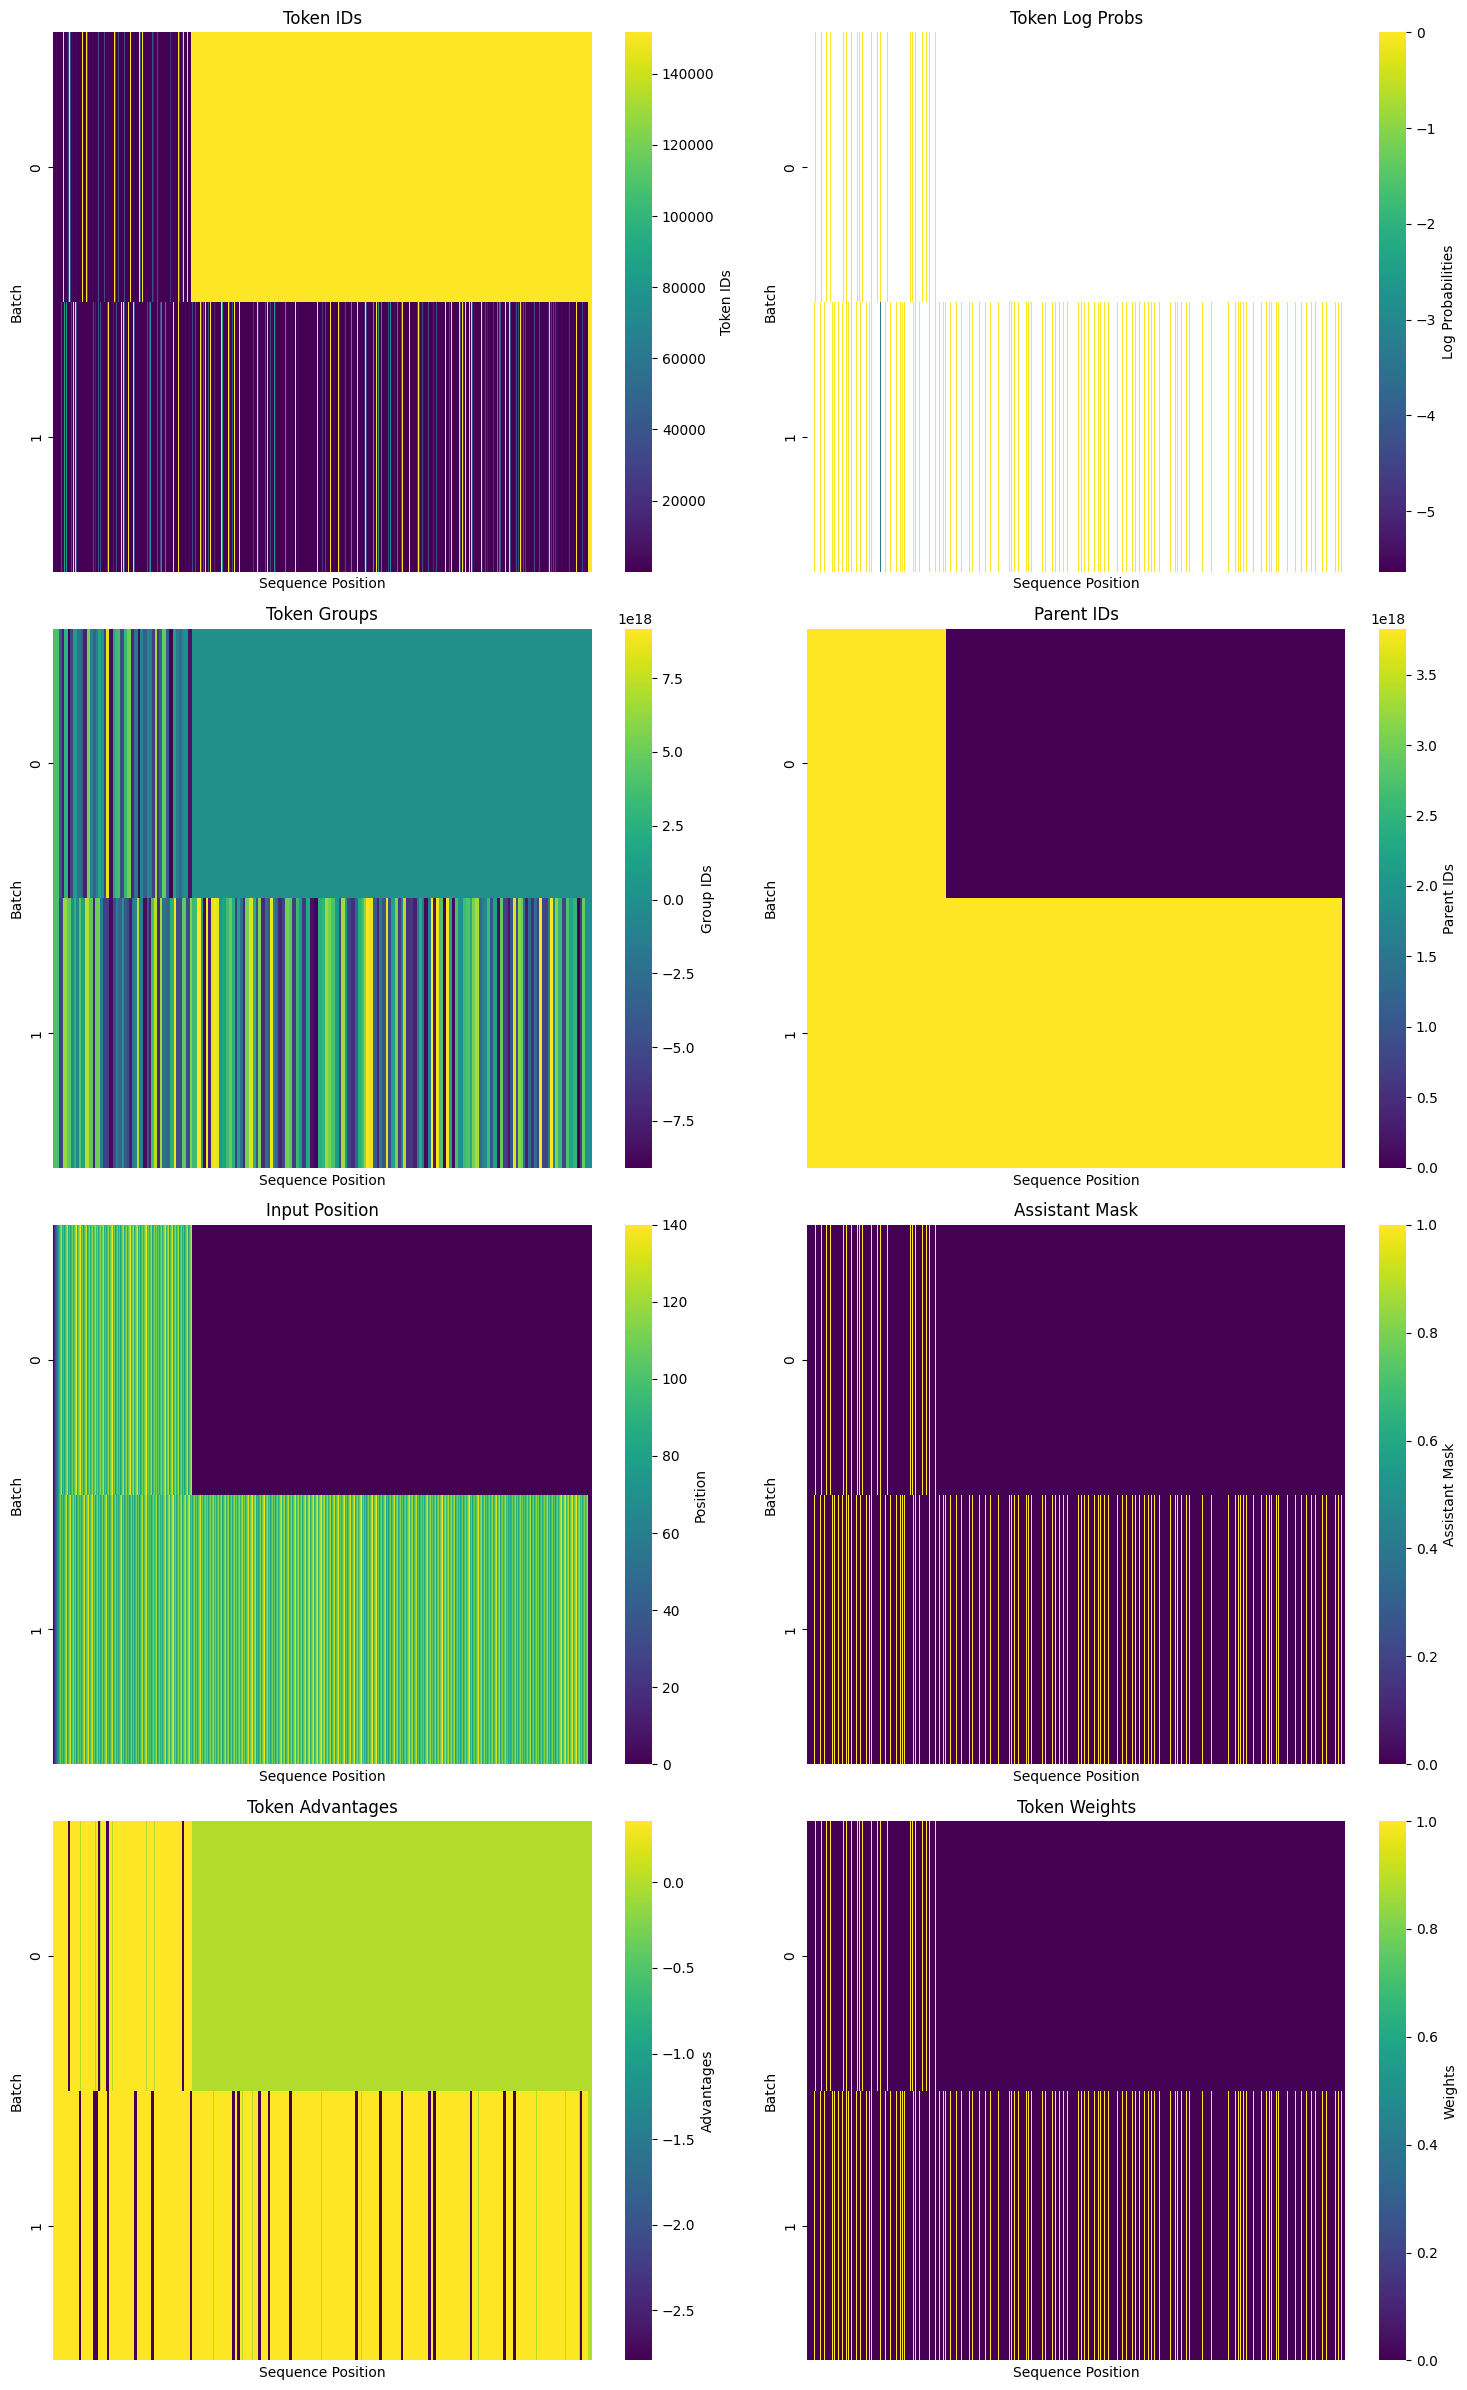

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0011


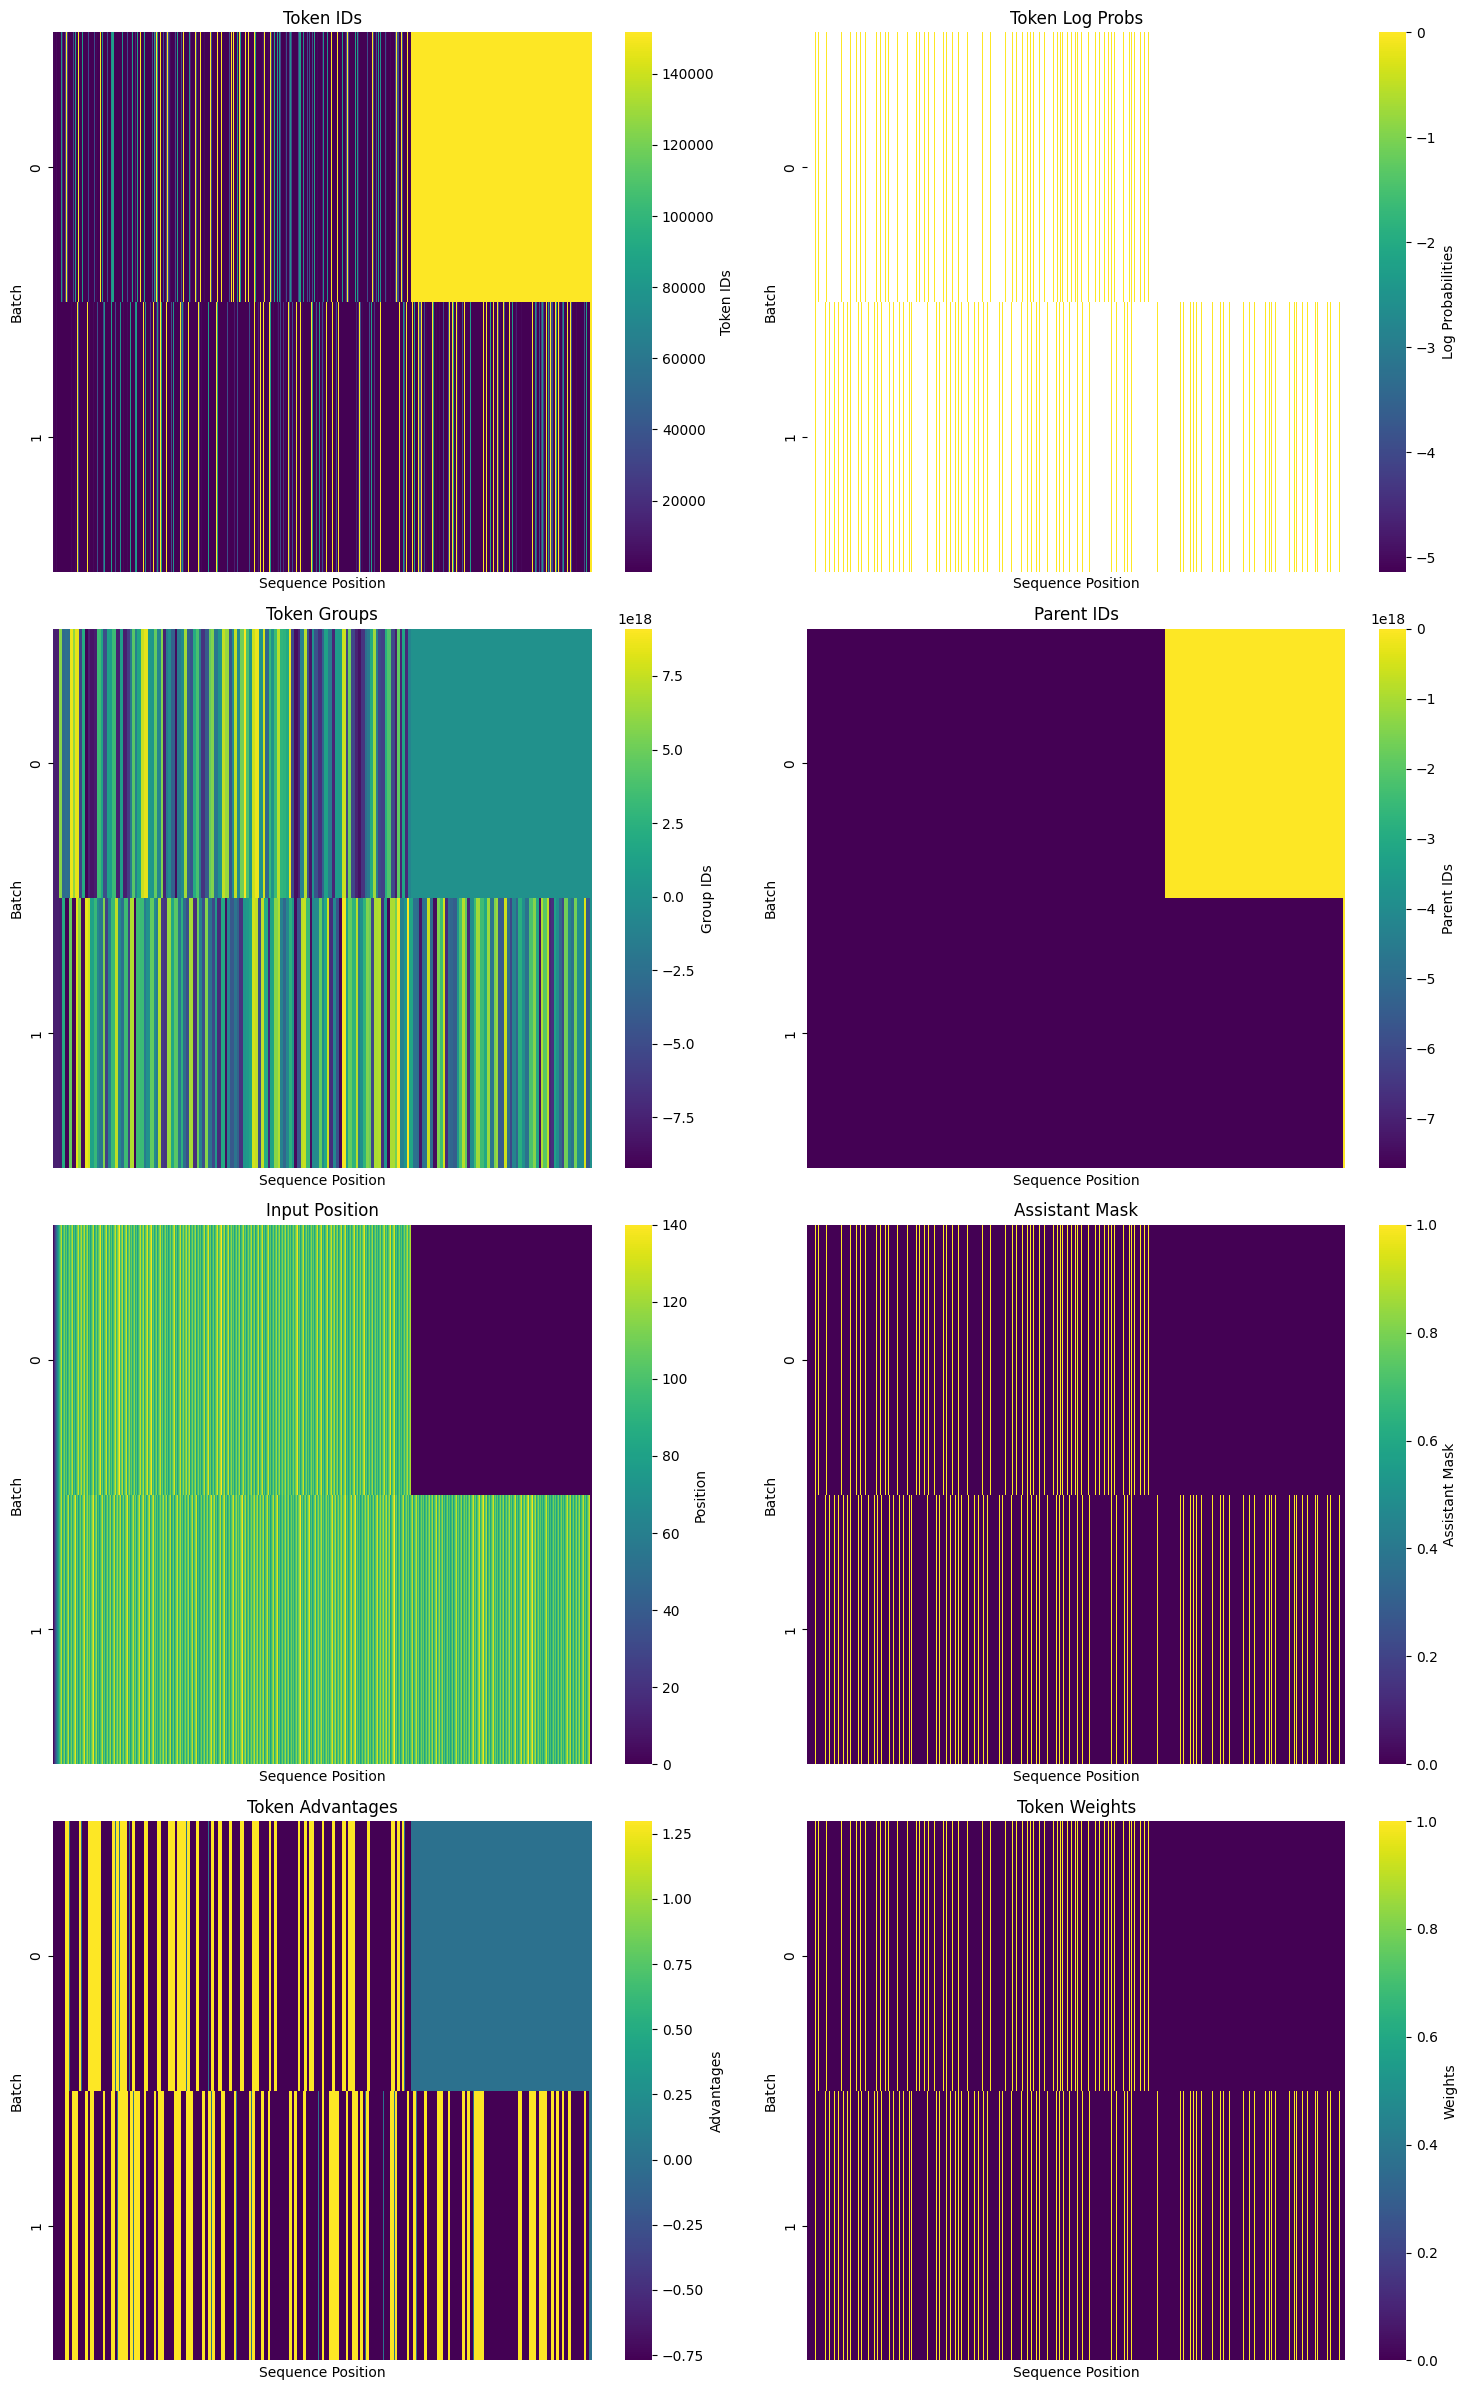

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0012


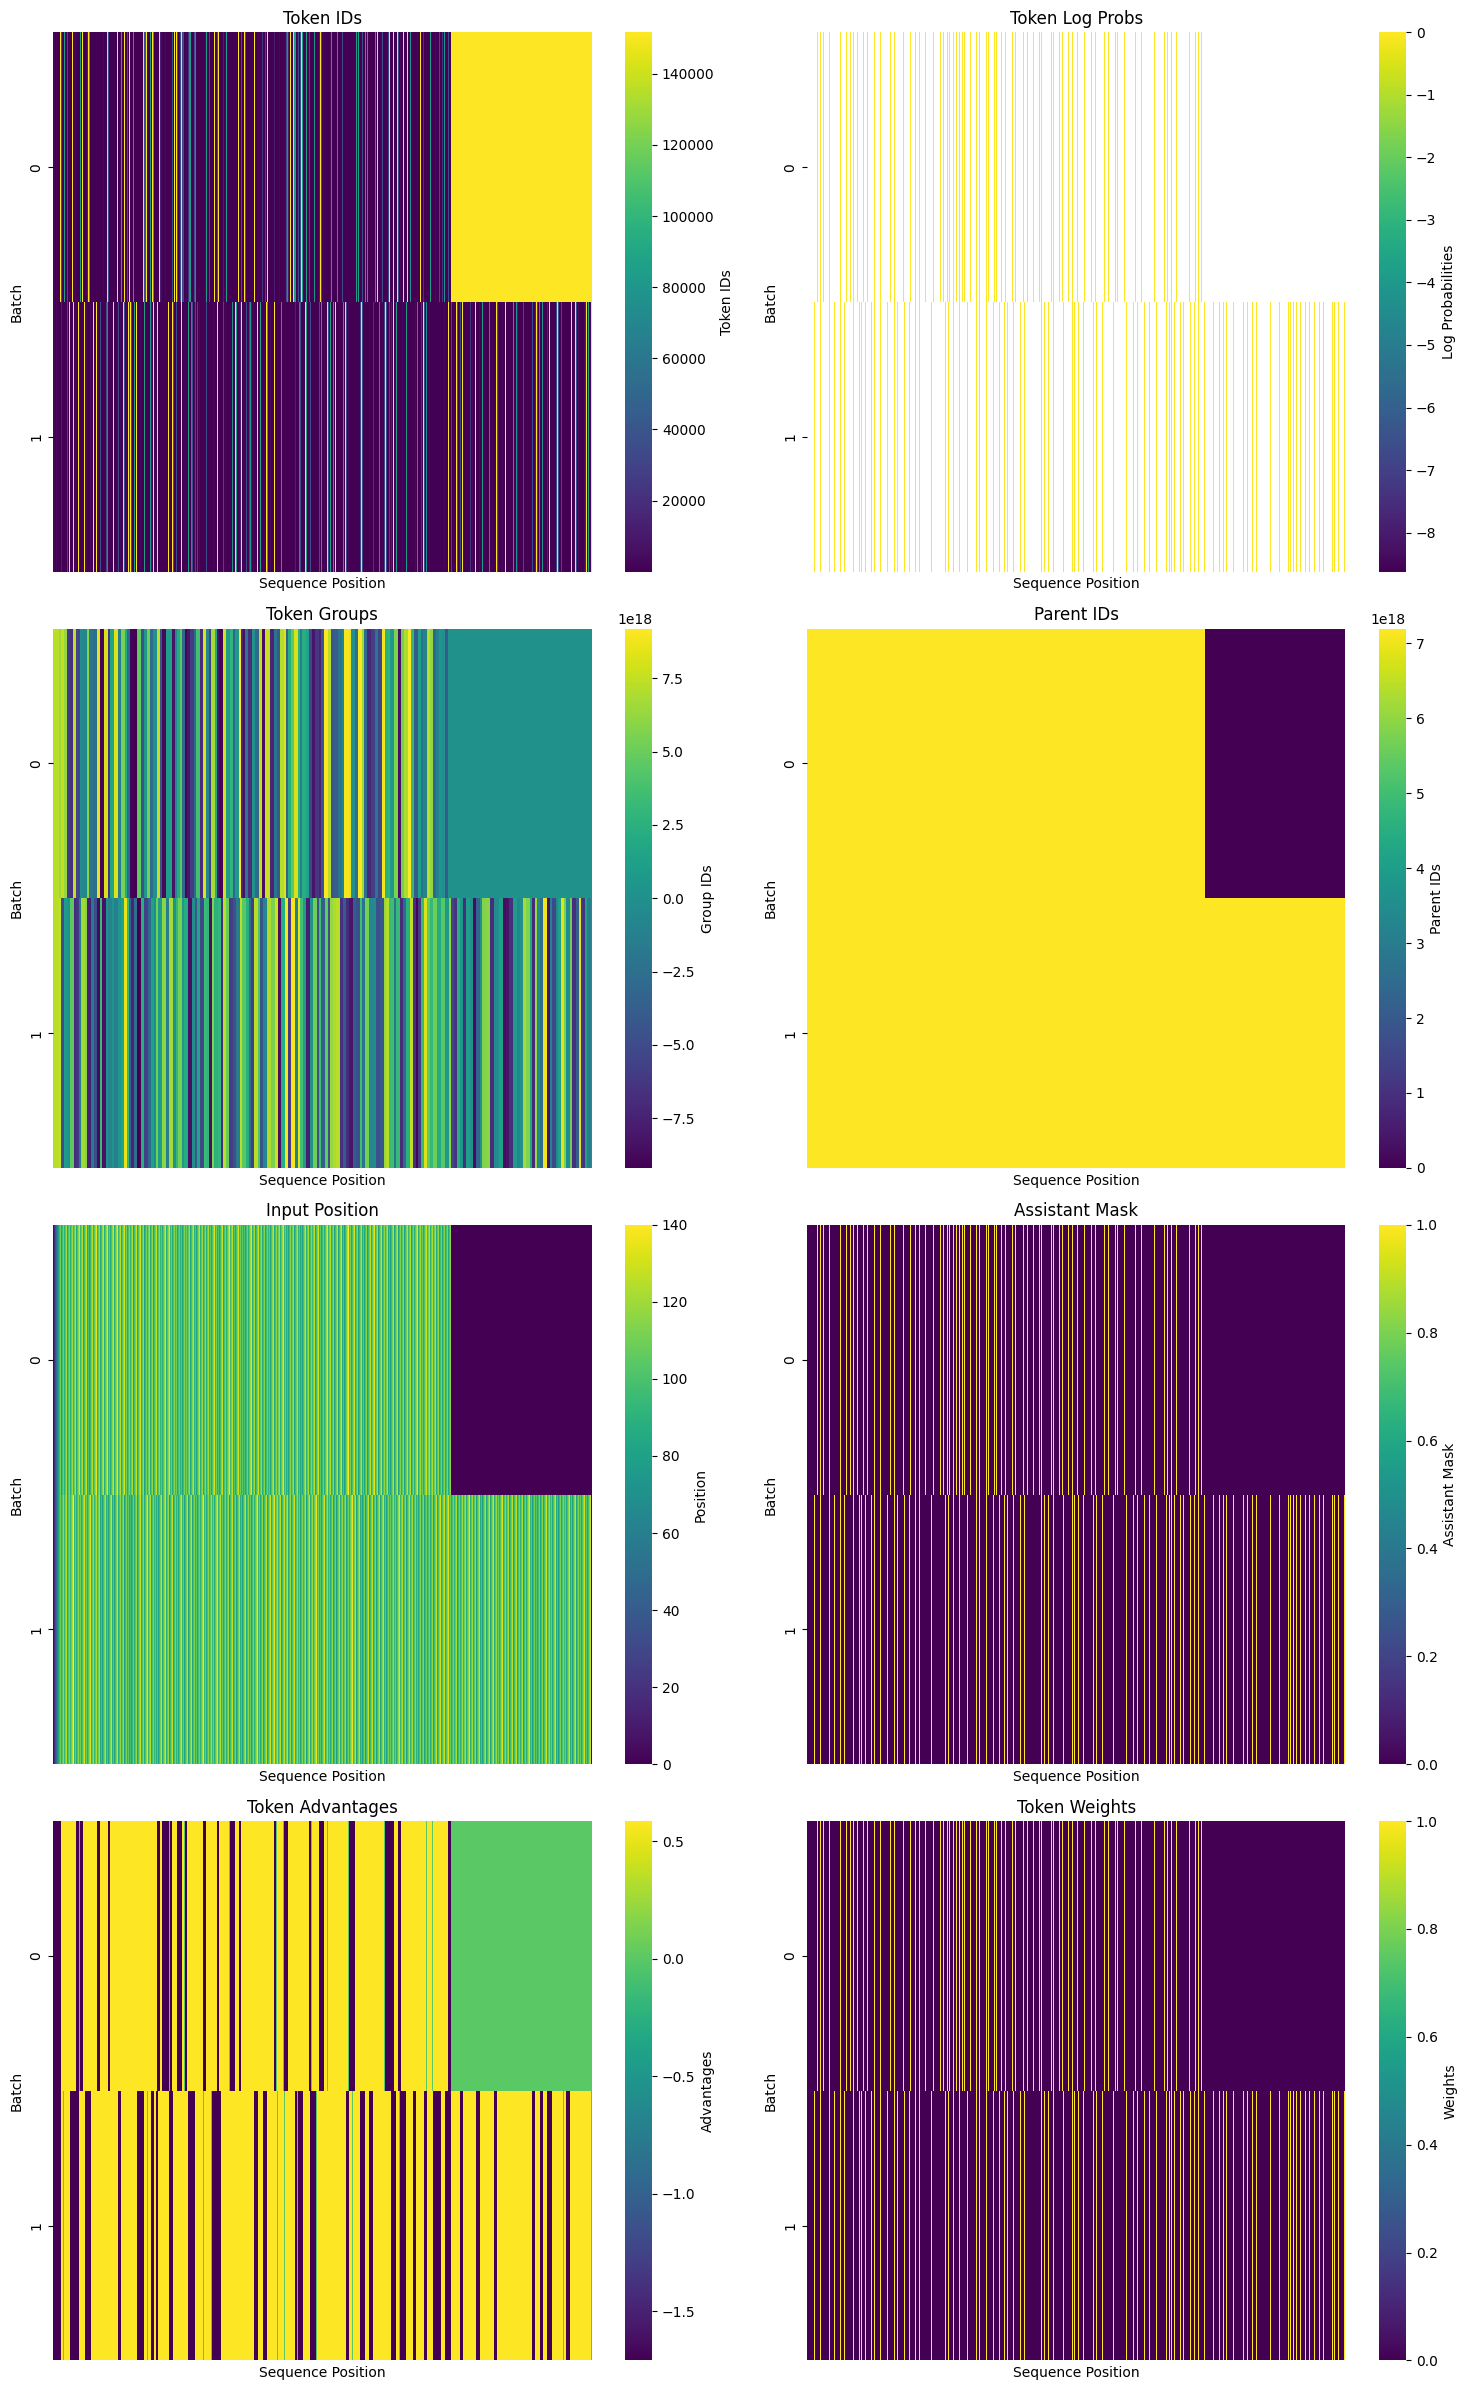

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0013
Skipping tuning as there is no suitable data.


train:   0%|          | 0/6 [00:00<?, ?it/s]

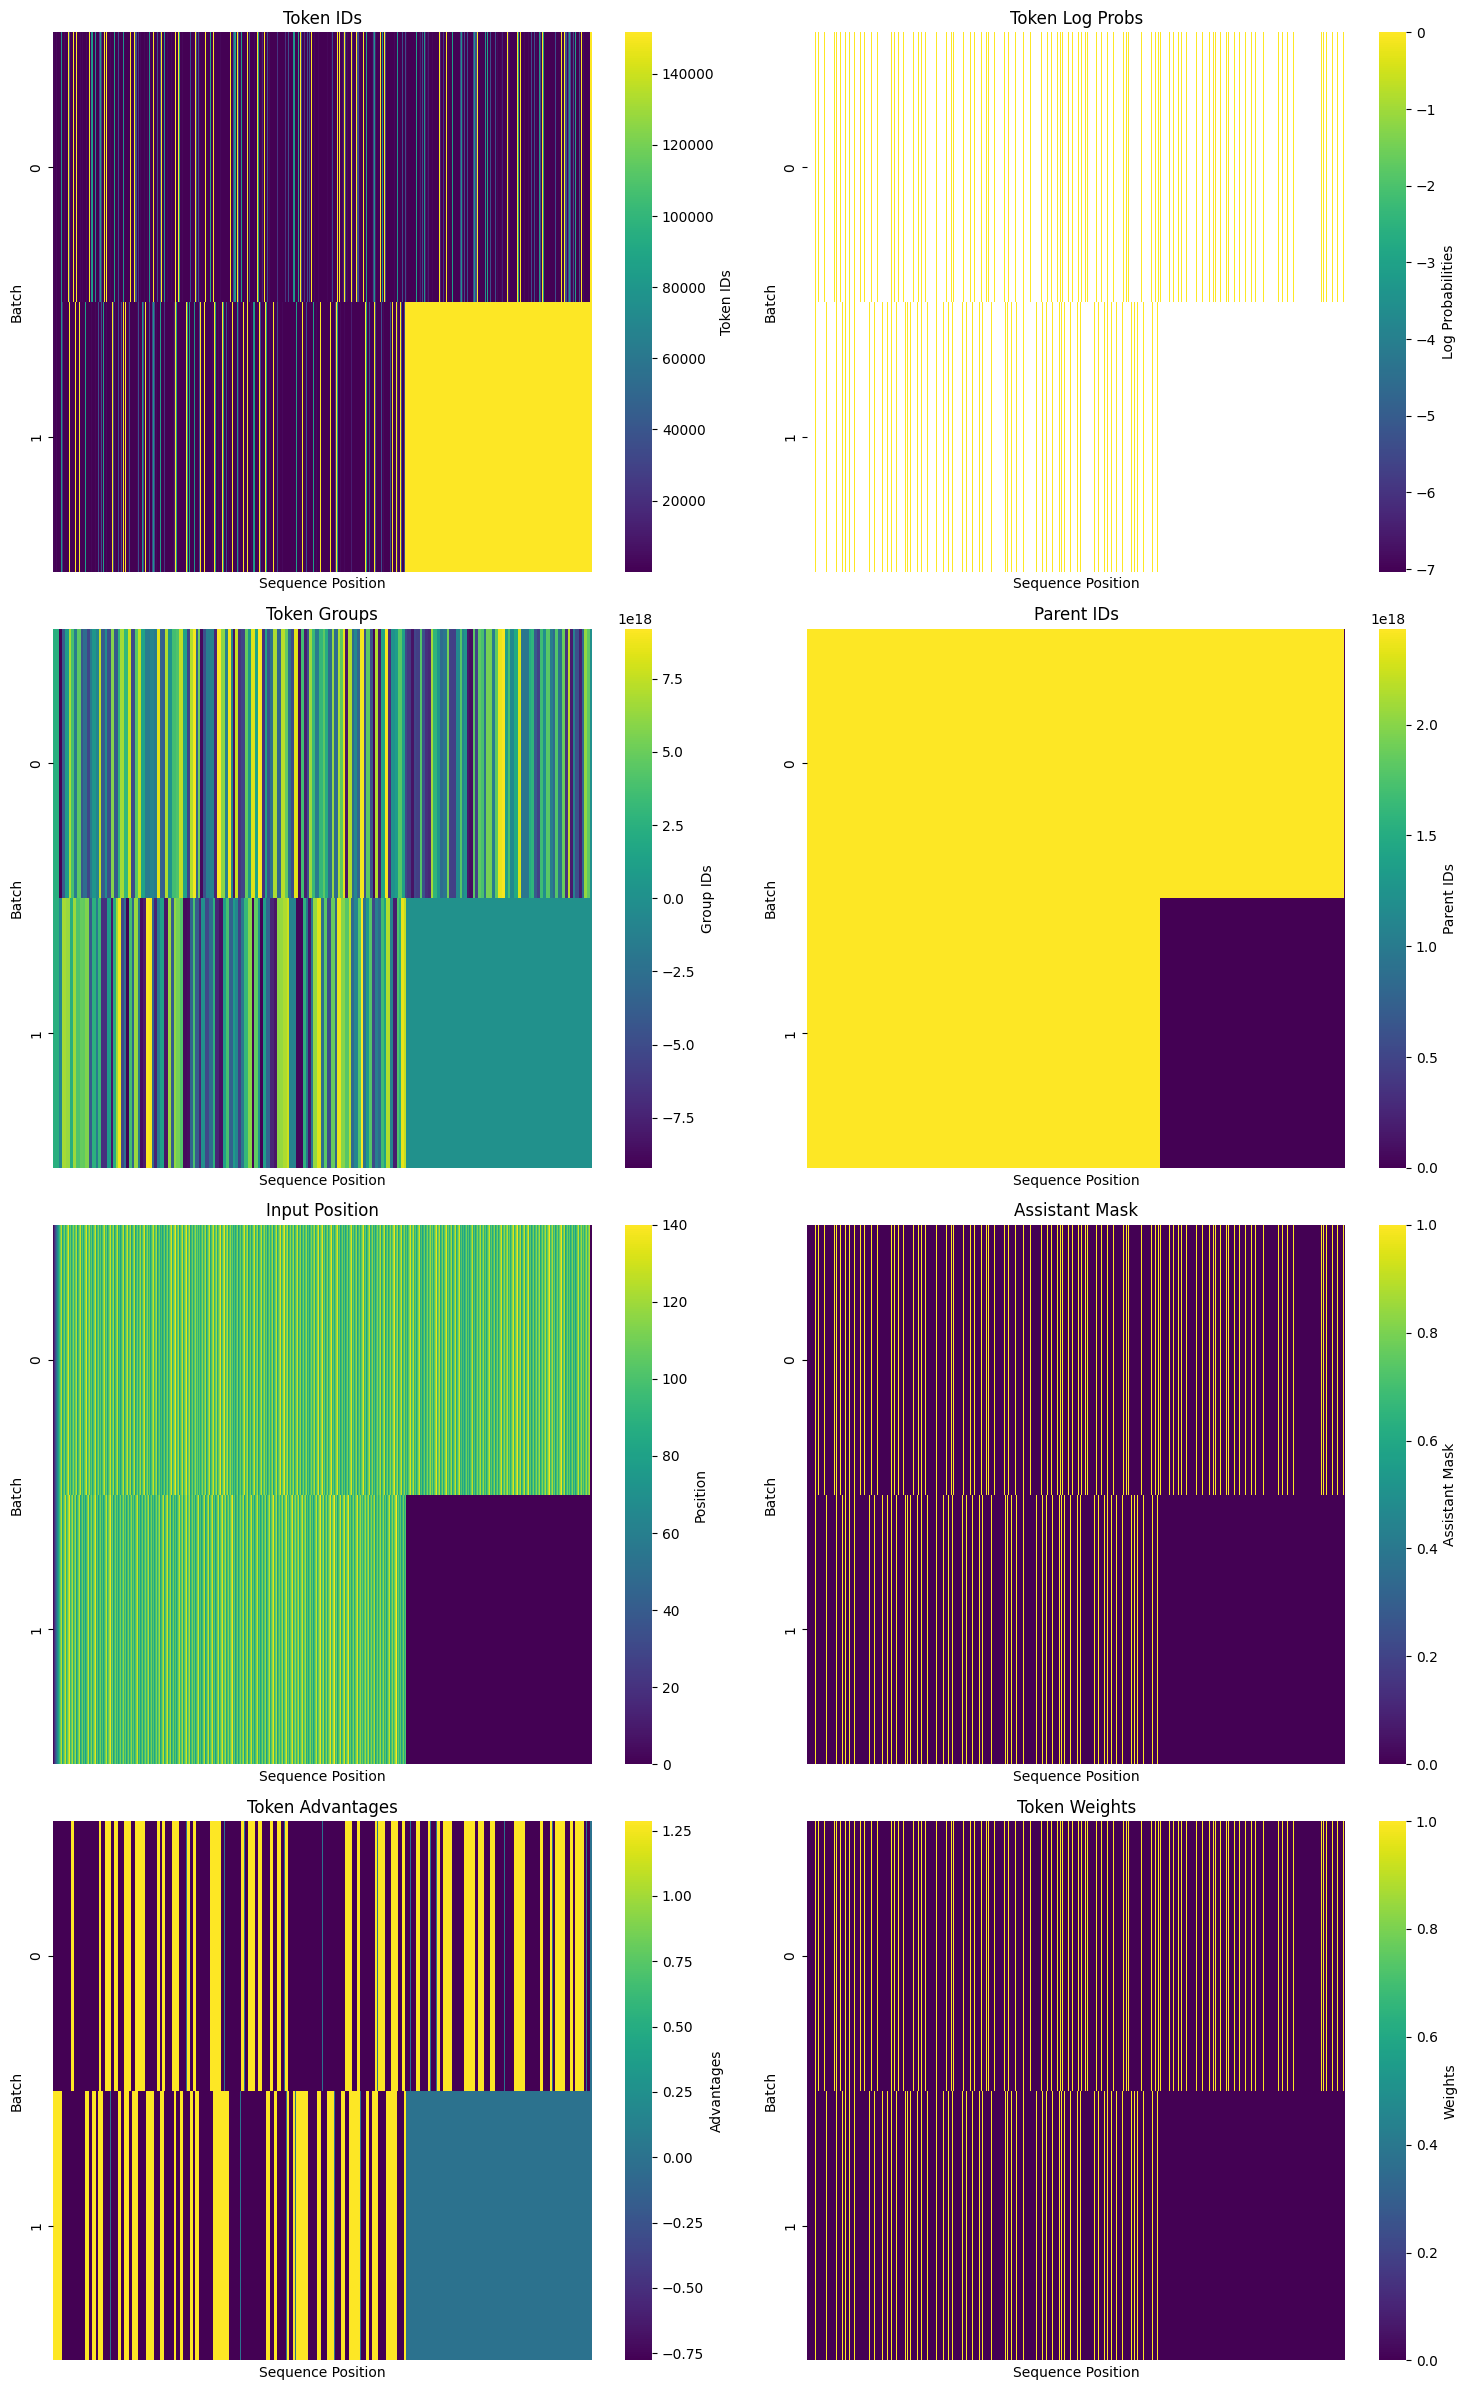

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/2048-single-game/0014


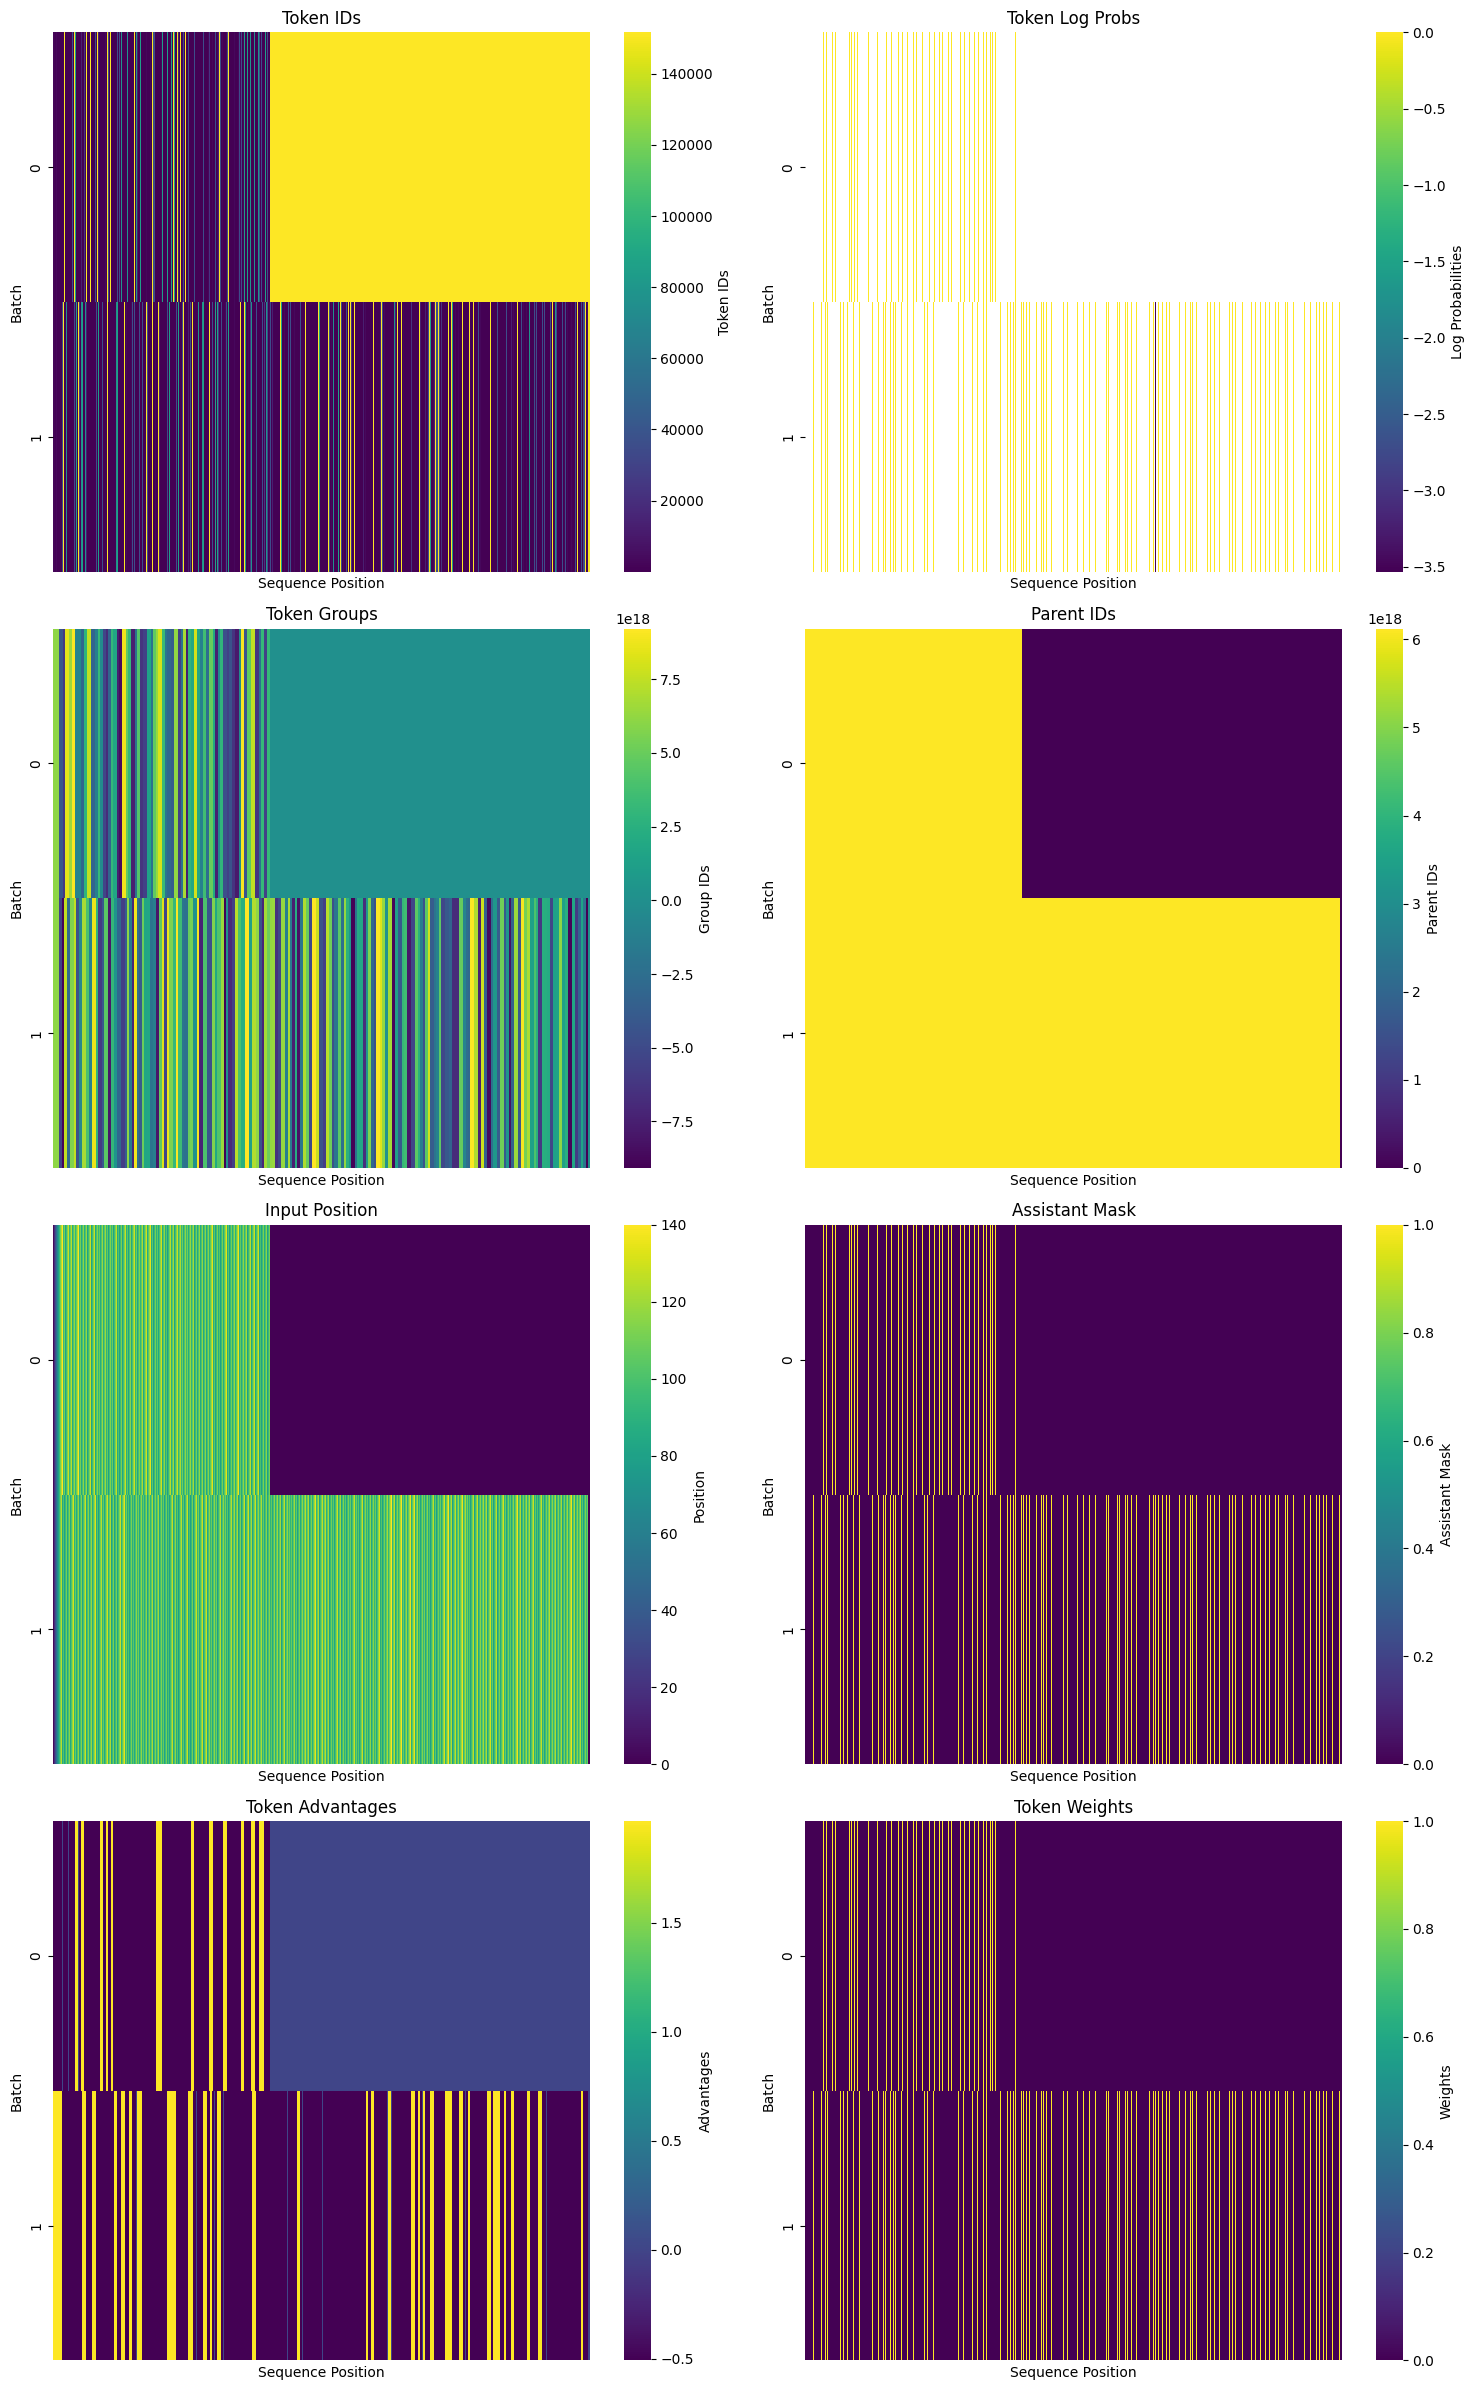

tune:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import art
import asyncio
from dotenv import load_dotenv
from art.utils.get_trajectory_messages import get_trajectory_messages
import json
import openai
import random
from typing import TypedDict
import time
from typing import Literal
from pydantic import BaseModel
import math
import string
import xml.etree.ElementTree as ET

load_dotenv()

WINNING_VALUE = 512


class TwentyFortyEightGame(TypedDict):
    id: str
    board: list[list[int | None]]

def populate_random_cell(game: TwentyFortyEightGame) -> None:
    all_clear_coordinates = [(i, j) for i in range(len(game["board"])) for j in range(len(game["board"][i])) if game["board"][i][j] is None]
    random_clear_coordinates = random.choice(all_clear_coordinates)
    # 90% chance to populate a 2, 10% chance to populate a 4
    game["board"][random_clear_coordinates[0]][random_clear_coordinates[1]] = 2 if random.random() < 0.9 else 4


def generate_game(board_length: int = 4) -> TwentyFortyEightGame:
    # random 6 character string
    id = ''.join(random.choices(string.ascii_letters + string.digits, k=6))
    game = {
        "id": id,
        "board": [[None for _ in range(board_length)] for _ in range(board_length)]
    }

    # populate two random cells
    populate_random_cell(game)
    populate_random_cell(game)
    
    return game


def render_board(game: TwentyFortyEightGame) -> str:
    board = game["board"]
    # print something like this:
    # _    | 2    | _    | 4
    # 4    | 8    | 2    | 16
    # 16   | 32   | 64   | 128
    # _    | 2    | 2    | 4
    # where _ is an empty cell

    max_cell_width = max([len(str(cell)) for row in board for cell in row if cell is not None])

    board_str = ""
    for row in board:
        # pad the cells with spaces to make them the same width
        board_str += "|".join([str(cell).rjust(max_cell_width) if cell is not None else "_".rjust(max_cell_width) for cell in row])
        board_str += "\n"
    return board_str

# condense, privileging matches at the start of the sequence
# sequences should be passed starting with cells that are the furthest in the direction in which the board is being condensed
def condense_sequence(sequence: list[int | None]) -> list[int | None]:
    condensed_sequence = []
    
    gapless_sequence = [cell for cell in sequence if cell is not None]

    i = 0
    while i < len(gapless_sequence):
        if i + 1 < len(gapless_sequence) and gapless_sequence[i] == gapless_sequence[i + 1]:
            condensed_sequence.append(gapless_sequence[i] * 2)
            i += 2
        else:
            condensed_sequence.append(gapless_sequence[i])
            i += 1

    # pad the sequence with None at the end
    return condensed_sequence + [None] * (4 - len(condensed_sequence))

def condense_board(game: TwentyFortyEightGame, direction: Literal["left", "right", "up", "down"]) -> None:

    if direction == "left":
        for row in game["board"]:
            condensed_row = condense_sequence(row)
            for i in range(len(row)):
                row[i] = condensed_row[i]
    
    if direction == "right":
        for row in game["board"]:
            reversed_row = row[::-1]
            # reverse the row before and after condensing
            condensed_row = condense_sequence(reversed_row)[::-1]
            for i in range(len(row)):
                row[i] = condensed_row[i]

    if direction == "up":
        for col_index in range(len(game["board"][0])):
            column = [row[col_index] for row in game["board"]]

            condensed_column = condense_sequence(column)
            for row_index in range(len(column)):
                game["board"][row_index][col_index] = condensed_column[row_index]
    
    if direction == "down":
        for col_index in range(len(game["board"][0])):
            column = [row[col_index] for row in game["board"]]
            reversed_column = column[::-1]
            condensed_column = condense_sequence(reversed_column)[::-1]
            for row_index in range(len(column)):
                game["board"][row_index][col_index] = condensed_column[row_index]
        
        

class AgentMove(BaseModel):
    direction: Literal["left", "right", "up", "down"]


def apply_agent_move(game: TwentyFortyEightGame, move_xml: str) -> None:

    direction = None
    # parse the move
    try:
        root = ET.fromstring(move_xml)
        direction = root.text
    except Exception as e:
        raise ValueError("Invalid xml")
    
    if direction not in ["left", "right", "up", "down"]:
        raise ValueError("Invalid direction")

    condense_board(game, direction)

    populate_random_cell(game)

def max_cell_value(game: TwentyFortyEightGame) -> int:
    return max([cell for row in game["board"] for cell in row if cell is not None])


def check_game_finished(game: TwentyFortyEightGame) -> bool:

    if max_cell_value(game) >= WINNING_VALUE:
        return True

    # check if any cell is empty
    if any(cell is None for row in game["board"] for cell in row):
        return False

    return True



failing_trajectory = None


@art.retry(exceptions=(openai.LengthFinishReasonError,))
async def rollout(
    client: openai.AsyncOpenAI, iteration: int, is_validation: bool
) -> art.Trajectory:

    game = generate_game()

    trajectories: list[art.Trajectory] = []
    reward = 0
    move_number = 0

    while True:
        trajectory = art.Trajectory(
            messages_and_choices=[
                {
                    "role": "system",
                    "content": "You are an excellent 2048 player. Always choose the move most likely to lead to combine cells to eventually reach the number 2048. Optional moves are 'left', 'right', 'up', 'down'. Return your move as an XML object with a single property 'move', like so: <move>left</move>",
                }
            ],
            reward=0,
            metrics={"test": 5},
        )

        trajectories.append(trajectory)
            
        trajectory.messages_and_choices.append(
            {"role": "user", "content": render_board(game)}
        )

        requested_at = int(time.time() * 1000)
        messages = get_trajectory_messages(trajectory)

        async def get_completion(timeout: int = 3):
            return await client.chat.completions.create(
                max_completion_tokens=2048,
                messages=messages,
                model=model.name,
                timeout=timeout,
            )

        try:
            try:
                chat_completion = await get_completion(timeout=3)
            except openai.TimeoutError as e:
                print("caught timeout error generating chat completion")
                chat_completion = await get_completion(timeout=10)
            last_completion = chat_completion
        except openai.LengthFinishReasonError as e:
            raise e
        except Exception as e:
            print("caught exception generating chat completion")
            print(e)
            global failing_trajectory
            failing_trajectory = trajectory
            raise e
        
        try:
            op_client.report(
                requested_at=requested_at,
                received_at=int(time.time() * 1000),
                req_payload={
                    "model": model.name,
                    "messages": messages,
                    "metadata": {
                        "game_id": game["id"],
                        "notebook-id": "2048",
                        "iteration": str(iteration),
                        "validation": str(is_validation),
                        "move_number": str(move_number),
                    },
                },
                resp_payload=chat_completion,
                status_code=200,
            )
        except Exception as e:
            print(f"Error reporting to OpenPipe: {e}")

        choice = chat_completion.choices[0]
        content = choice.message.content
        assert isinstance(content, str)
        trajectory.messages_and_choices.append(choice)

        try:
            apply_agent_move(game, content)
            move_number += 1
        except ValueError:
            reward = -1
            break

        if check_game_finished(game):
            max_value = max_cell_value(game)

            if max_value < WINNING_VALUE:
                # scale reward logarithmically between 0 for 2 and 1 for 2048
                reward = (math.log(max_value, 2) - 1) / (math.log(WINNING_VALUE, 2) - 1)
            else:
                # double reward if it wins
                reward = 2
            break

    for trajectory in trajectories:
        trajectory.reward = reward
    
    try:
        op_client.update_log_metadata(
            filters=[
                {
                    "field": "completionId",
                    "equals": last_completion.id,
                }
            ],
            metadata={
                "reward": str(reward),
                "reward_assigned": "true",
            }
        )
    except Exception as e:
        print(f"Error updating log metadata: {e}")

    return trajectories

persistent_client = None

openai_client = await model.openai_client()

for i in range(await model.get_iteration(), 500):
    train_groups = await art.gather_trajectories(
        (
            rollout(openai_client, i, is_validation=False) for _ in range(6)
        ),
        pbar_desc="train",
        return_exceptions=False,
    )

    # combine train_groups into a single list
    train_groups = [[item for sublist in train_groups for item in sublist]]

    await model.clear_iterations()
    await model.tune(
        train_groups, config=art.TuneConfig(plot_tensors=True, lr=3e-5)
    )